# Citibike Modeling

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
import datetime as dt
from datetime import timedelta
import random
from collections import Counter
from scipy import sparse
import pickle
import pandas.api.types as ptypes

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import patsy
from tqdm import tqdm

import dask
import dask.dataframe as dd
from dask.distributed import Client, progress

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam
import tensorflow
from tensorflow.keras.models import load_model

from citibike_preprocessing import read_data_dask, count_missing_dates

Using TensorFlow backend.
/home/jlee_sbu/anaconda3/envs/metis/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jlee_sbu/anaconda3/envs/metis/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jlee_sbu/anaconda3/envs/metis/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

## Forecast with Facebook Prophet

In [2]:
# read pickled dataframe
citibike_df = pd.read_pickle('citibike_df_preprocessed.pkl')

In [3]:
# add column for whether day is during weekend
citibike_df['is_weekend'] = [True if (x == 5 or x == 6) else False for x in citibike_df.day_of_week]
citibike_df['not_weekend'] = [False if (x == 5 or x == 6) else True for x in citibike_df.day_of_week]

# add column for whether day is in a warm month (may-sept)
citibike_df['is_warm'] = [True if x in [5,6,7,8,9] else False for x in citibike_df.month]
citibike_df['not_warm'] = [False if x in [5,6,7,8,9] else True for x in citibike_df.month]

# reorder columns
citibike_df = citibike_df[['date', 'station_id', 'station_name', 'station_latitude',
                           'station_longitude', 'mean_duration', 'year', 'month', 'day_of_week',
                           'is_weekend', 'not_weekend', 'is_warm', 'not_warm',
                           'ride_counts','replace_zeroes', 'ride_counts_clean']]

# drop some columns and reset index
citibike_df = citibike_df.drop(['ride_counts', 'replace_zeroes'], axis=1)
citibike_df = citibike_df.reset_index(drop=True)

In [4]:
# head of dataframe
citibike_df.head()

date  station_id              station_name  station_latitude  \
0 2015-01-01          79  Franklin St & W Broadway         40.719116   
1 2015-01-02          79  Franklin St & W Broadway         40.719116   
2 2015-01-03          79  Franklin St & W Broadway         40.719116   
3 2015-01-04          79  Franklin St & W Broadway         40.719116   
4 2015-01-05          79  Franklin St & W Broadway         40.719116   

   station_longitude  mean_duration  year  month  day_of_week  is_weekend  \
0         -74.006667     880.133333  2015      1            3       False   
1         -74.006667    1499.818182  2015      1            4       False   
2         -74.006667     432.266667  2015      1            5        True   
3         -74.006667     693.666667  2015      1            6        True   
4         -74.006667     669.000000  2015      1            0       False   

   not_weekend  is_warm  not_warm  ride_counts_clean  
0         True    False      True                 15  
1         True    False      True                 22  
2        False    False      True                 15  
3        False    False      True                 27  
4         True    False      True                 27

In [4]:
# create dataframe for notable days including summer streets events and observance days
summer_streets = pd.DataFrame({
  'holiday': 'summer_streets',
  'ds': pd.to_datetime(['2015-08-01', '2015-08-08', '2015-08-15',
                        '2016-08-06', '2016-08-13', '2016-08-20',
                        '2017-08-05', '2017-08-12', '2017-08-19',
                        '2018-08-04', '2018-08-11', '2018-08-18',
                        '2019-08-03', '2019-08-10', '2019-08-17']),
  'lower_window': 0,
  'upper_window': 0,
})

mothers_day = pd.DataFrame({
  'holiday': 'mothers_day',
  'ds': pd.to_datetime(['2015-05-10', '2016-05-08', '2017-05-14', '2018-05-13', '2019-05-12']),
  'lower_window': 0,
  'upper_window': 0,
})

fathers_day = pd.DataFrame({
  'holiday': 'fathers_day',
  'ds': pd.to_datetime(['2015-06-21', '2016-06-19', '2017-06-18', '2018-06-17', '2019-06-16']),
  'lower_window': 0,
  'upper_window': 0,
})

holidays = pd.concat((summer_streets, mothers_day, fathers_day))

### Functions to leverage throughout notebook

In [5]:
# mean absolute error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

# mean absolute percentage error (MAPE)
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))  

In [6]:
# plot predictions against actuals and print metric results
def plot_forecast(y_true, y_pred, title='Forecast of bike usage volume from station', 
                  xlabel='Day #', ylabel='# of Citibike Rides', 
                  grid=True, figsize=(10, 6)):
    
    if len(y_true) != len(y_pred):
        return_str = 'Unequal lengths error: '
        return_str += '({} actual, '.format(len(y_true))
        return_str += '{} forecast)'.format(len(y_pred))
        return return_str
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(range(1,365+1), y_true, color='darkorange')
    ax.plot(y_pred, color='teal', linestyle='--')
    ax.set_facecolor('whitesmoke')
    ax.title.set_text(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(['Actual','Predictions']);

###

#     plt.figure(figsize=figsize)
#     plt.plot(actual, label='Actual')
#     plt.plot(actual.index, pred, label='Predicted', c='r', alpha=0.7)
#     plt.title(title)
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
    #plt.xticks(actual.index.date[::24], # .date
    #           actual.index.day[::24]) # .day
    #plt.xlim(min(actual.index.date), max(actual.index.date)) #.date # .date
    #plt.xlim(min(citibike_pred.date), max(citibike_pred.date)) 
    #plt.legend(loc=0)

###

# # metric evaluation for station
#     print('MAE: ', mae(y_actual, y_pred).round(5))
#     print('MAPE: ', mape(y_actual, y_pred).round(5))
#     print('RMSE: ', rmse(y_actual, y_pred).round(5))   

In [7]:
# add additional seasonalities
# whether day is sat or sun
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.weekday() == 5 or date.weekday() == 6)
    
# whether day is in warm month (may-sept)
def is_warm(ds):
    date = pd.to_datetime(ds)
    return (date.month in [5,6,7,8,9])

### Forecast several select stations

#### E 24 St & Park Ave S (491):

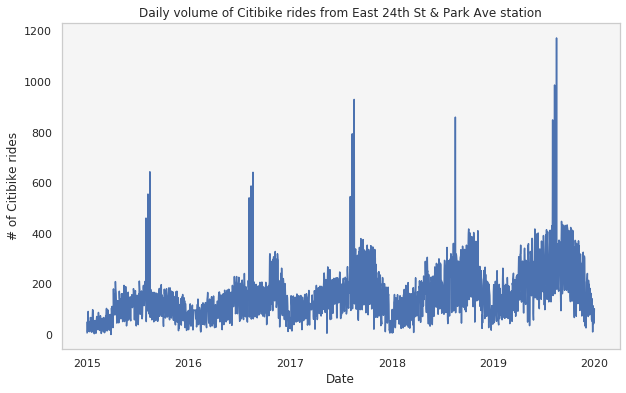

In [461]:
# plot daily ride counts for a specific station
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(citibike_df[citibike_df.station_id == 491].date, 
         citibike_df[citibike_df.station_id == 491].ride_counts_clean)
ax.set_facecolor('whitesmoke')
ax.title.set_text('Daily volume of Citibike rides from East 24th St & Park Ave station')
ax.set_xlabel('Date')
ax.set_ylabel('# of Citibike rides');

In [364]:
# split train, validation and test for a select station - 491
citibike_station = citibike_df.loc[citibike_df.station_id == 491, 
                                   ['date', 'is_weekend', 'not_weekend',
                                    'is_warm', 'not_warm', 'ride_counts_clean']] 

last_date = pd.Timestamp(2019, 12, 31) 
delta = timedelta(days = 364)
test_start_date = last_date - delta # test date begins 1/01/2019
#test_start_date = pd.Timestamp(2019, 1, 1) 

station_cv = citibike_station.loc[(citibike_station.date < test_start_date), 
                                      ['date', 'is_weekend', 'not_weekend', 
                                       'is_warm', 'not_warm', 'ride_counts_clean']]

station_test = citibike_station.loc[(citibike_station.date >= test_start_date), 
                                  ['date', 'is_weekend', 'not_weekend', 
                                   'is_warm', 'not_warm', 'ride_counts_clean']]

station_cv.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']
station_test.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']

In [365]:
# create prophet object with parameters, fit with train data and do cross validation 
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #) #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

m.fit(station_cv)

cv_results = cross_validation(m, initial='730 days', horizon='365 days') 
print(cv_results)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-12-31 00:00:00 and 2017-12-31 00:00:00


             ds        yhat  yhat_lower  yhat_upper    y     cutoff
0    2017-01-01  -40.676305  -74.851168   -8.277798   33 2016-12-31
1    2017-01-02  153.935404  119.408384  188.866881   25 2016-12-31
2    2017-01-03  171.791524  136.544861  204.229332   33 2016-12-31
3    2017-01-04  172.906189  137.143348  204.858852  155 2016-12-31
4    2017-01-05  161.711509  125.662326  196.254517  133 2016-12-31
...         ...         ...         ...         ...  ...        ...
1090 2018-12-27  227.381836 -339.094975  786.411410  116 2017-12-31
1091 2018-12-28  176.906444 -269.095654  598.777152   43 2017-12-31
1092 2018-12-29   12.261357  -41.725993   64.882766   50 2017-12-31
1093 2018-12-30   14.492606  -41.576700   69.429224   50 2017-12-31
1094 2018-12-31  172.910768 -268.418153  597.513252   59 2017-12-31

[1095 rows x 6 columns]


In [366]:
# evaluation metrics
performance_results = performance_metrics(cv_results, metrics=['mae', 'mape', 'rmse'])
print("Mean MAE:", np.mean(performance_results.mae))
print("Mean MAPE:", np.mean(performance_results.mape))
print("Mean RMSE:", np.mean(performance_results.rmse))

Mean MAE: 64.56165688184079
Mean MAPE: 0.6874501343140363
Mean RMSE: 82.78038221500934


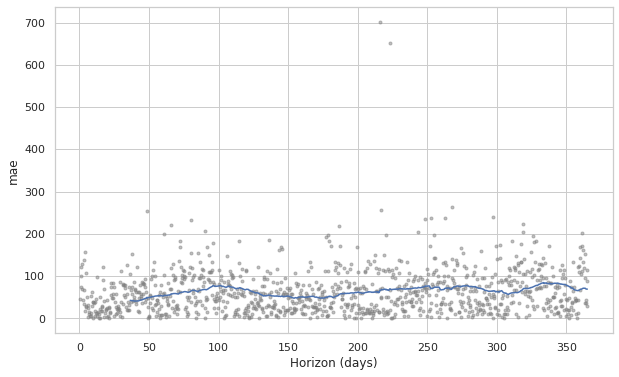

In [368]:
fig = plot_cross_validation_metric(cv_results, metric='mae')

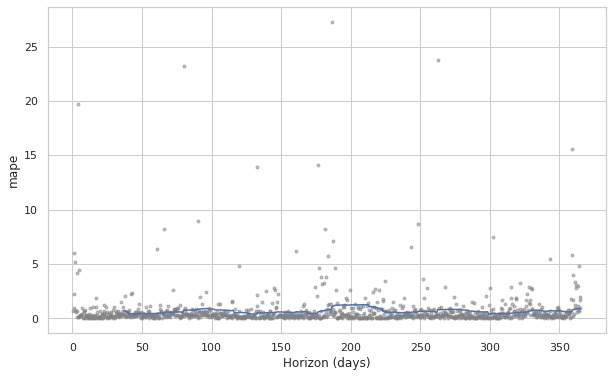

In [369]:
fig = plot_cross_validation_metric(cv_results, metric='mape')

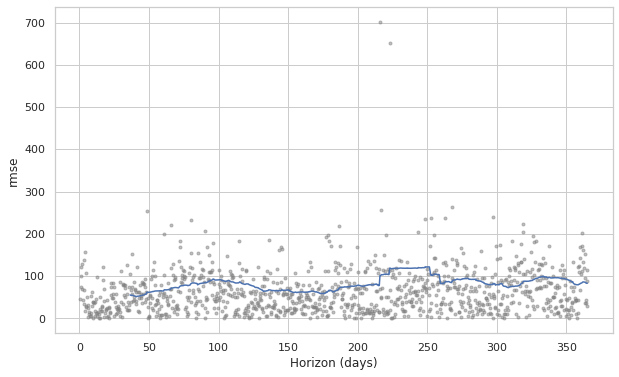

In [367]:
fig = plot_cross_validation_metric(cv_results, metric='rmse')

**With final model, make predictions on test set (2019)**

In [370]:
# create prophet object with parameters, fit with entire train data and predict on test set
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #) #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

# fit model to entire training data
m.fit(station_cv)

# predict using test set
future = m.make_future_dataframe(periods=365, freq='d') # 181 # include_history=False) 
future['is_weekend'] = future['ds'].apply(is_weekend)
future['not_weekend'] = ~future['ds'].apply(is_weekend)
future['is_warm'] = future['ds'].apply(is_warm)
future['not_warm'] = ~future['ds'].apply(is_warm)

forecast = m.predict(future)

In [371]:
# merge predictions back to main dataframe
citibike_pred = citibike_df[(citibike_df.station_id == 491) & 
                            (citibike_df.year == 2019)].merge( 
    forecast[['ds','yhat','yhat_lower','yhat_upper']], how='left', left_on=['date'], right_on=['ds'])

citibike_pred = citibike_pred.drop(['ds', 'year', 'month'], axis=1) 

citibike_pred.yhat = citibike_pred.yhat.apply(np.ceil).astype(int)

citibike_pred['error'] = citibike_pred.yhat - citibike_pred.ride_counts_clean
citibike_pred['error_abs'] = abs(citibike_pred.yhat - citibike_pred.ride_counts_clean).astype(int)
citibike_pred['error_sq'] = ((citibike_pred.yhat - citibike_pred.ride_counts_clean)**2).astype(int)

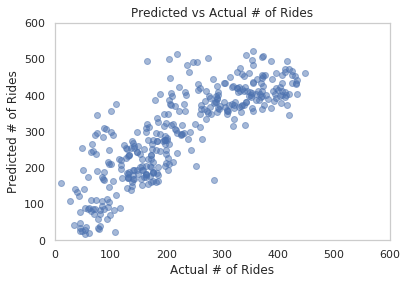

In [372]:
# plot predicted vs actual
plt.scatter(citibike_pred.ride_counts_clean, citibike_pred.yhat, alpha=0.5)
plt.title("Predicted vs Actual # of Rides"), plt.xlabel("Actual # of Rides"), plt.ylabel("Predicted # of Rides")
plt.xlim(0, 600), plt.ylim(0, 600);

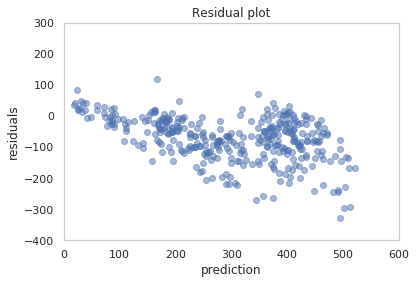

In [373]:
# plot residuals
#diagnostic_plot(X_test, y_test)
residuals = citibike_pred.ride_counts_clean - citibike_pred.yhat
plt.scatter(citibike_pred.yhat, residuals, alpha=0.5)
plt.title("Residual plot"), plt.xlabel("prediction"), plt.ylabel("residuals")
plt.xlim(0, 600), plt.ylim(-400, 300);

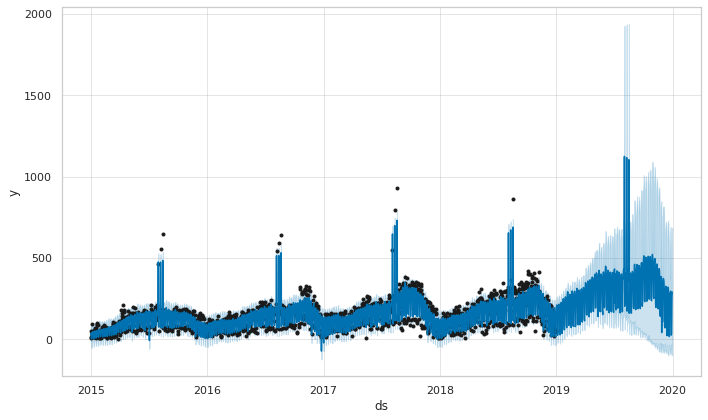

In [374]:
# plot forecast dataframe
fig1 = m.plot(forecast) 

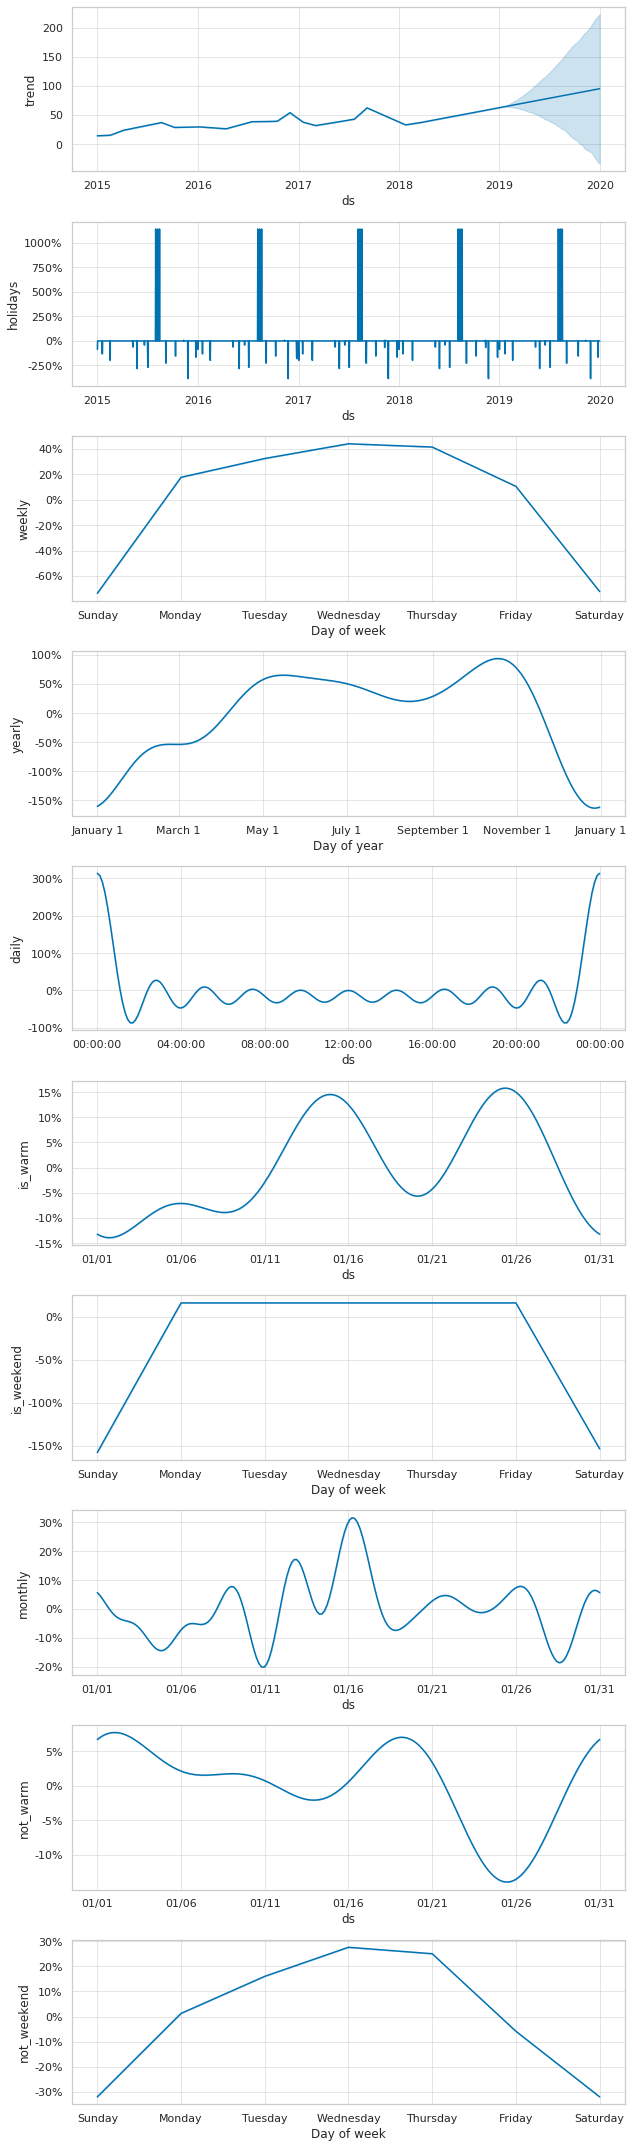

In [375]:
# plot forecast components
fig2 = m.plot_components(forecast)

In [376]:
# evaluation metrics
print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 78.797
MAPE: 53.321
RMSE: 101.032


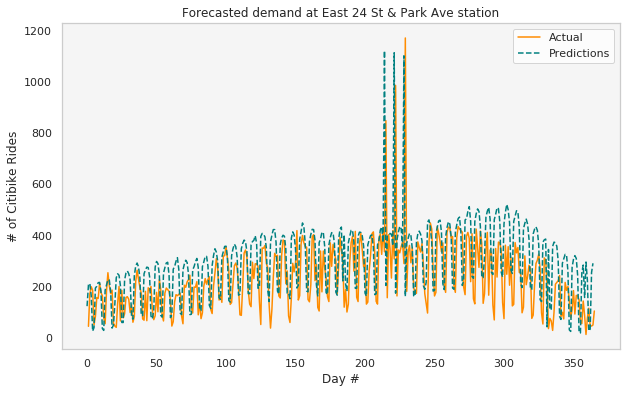

In [388]:
# plot predictions vs actual
plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at East 24 St & Park Ave station')

#### W 31 St & 7 Ave (379):

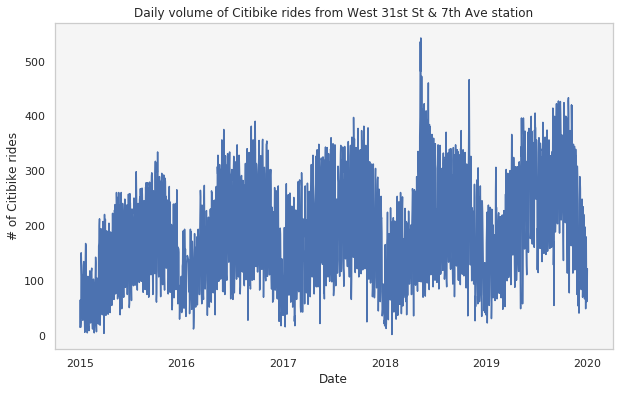

In [462]:
# plot daily ride counts for a specific station
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(citibike_df[citibike_df.station_id == 379].date, 
         citibike_df[citibike_df.station_id == 379].ride_counts_clean)
ax.set_facecolor('whitesmoke')
ax.title.set_text('Daily volume of Citibike rides from West 31st St & 7th Ave station')
ax.set_xlabel('Date')
ax.set_ylabel('# of Citibike rides');

In [389]:
# split train, validation and test for a select station - 379
citibike_station = citibike_df.loc[citibike_df.station_id == 379, 
                                   ['date', 'is_weekend', 'not_weekend',
                                    'is_warm', 'not_warm', 'ride_counts_clean']] 

last_date = pd.Timestamp(2019, 12, 31) 
delta = timedelta(days = 364)
test_start_date = last_date - delta # test date begins 1/01/2019
#test_start_date = pd.Timestamp(2019, 1, 1) 

station_cv = citibike_station.loc[(citibike_station.date < test_start_date), 
                                      ['date', 'is_weekend', 'not_weekend', 
                                       'is_warm', 'not_warm', 'ride_counts_clean']]

station_test = citibike_station.loc[(citibike_station.date >= test_start_date), 
                                  ['date', 'is_weekend', 'not_weekend', 
                                   'is_warm', 'not_warm', 'ride_counts_clean']]

station_cv.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']
station_test.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']

In [390]:
# create prophet object with parameters, fit with train data and predict future
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #100
            changepoint_prior_scale = 0.2) # .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

m.fit(station_cv)

cv_results = cross_validation(m, initial='730 days', horizon='365 days') 
print(cv_results)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-12-31 00:00:00 and 2017-12-31 00:00:00


             ds        yhat  yhat_lower  yhat_upper    y     cutoff
0    2017-01-01  -35.732487  -79.915158   11.989037   37 2016-12-31
1    2017-01-02  164.081355  119.976091  207.539499   39 2016-12-31
2    2017-01-03  191.033504  145.039598  236.400452  106 2016-12-31
3    2017-01-04  192.506860  142.912447  236.222055  166 2016-12-31
4    2017-01-05  181.565320  137.443822  223.232165  197 2016-12-31
...         ...         ...         ...         ...  ...        ...
1090 2018-12-27  143.967859 -221.962060  505.475732  133 2017-12-31
1091 2018-12-28  111.792521 -174.244960  397.092739   42 2017-12-31
1092 2018-12-29   21.431992  -53.921043   94.343590   79 2017-12-31
1093 2018-12-30   23.370476  -57.304511  104.903864   85 2017-12-31
1094 2018-12-31  114.991772 -190.041294  402.252061   38 2017-12-31

[1095 rows x 6 columns]


In [391]:
# evaluation metrics
performance_results = performance_metrics(cv_results, metrics=['mae', 'mape', 'rmse'])
print("Mean MAE:", np.mean(performance_results.mae))
print("Mean MAPE:", np.mean(performance_results.mape))
print("Mean RMSE:", np.mean(performance_results.rmse))

Mean MAE: 116.95720528865138
Mean MAPE: 0.7834799938396732
Mean RMSE: 139.3493894229544


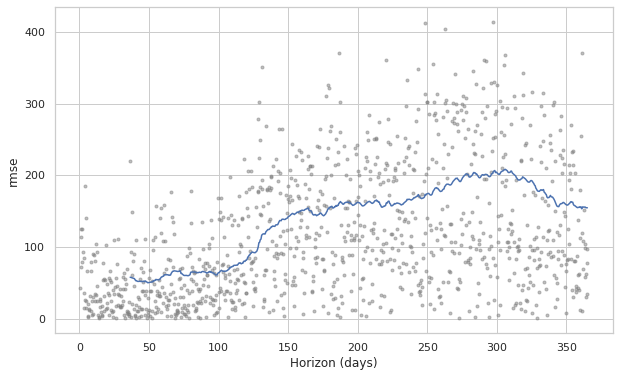

In [392]:
fig = plot_cross_validation_metric(cv_results, metric='rmse')

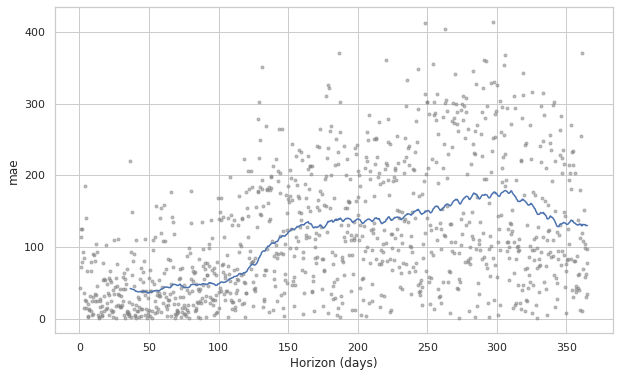

In [393]:
fig = plot_cross_validation_metric(cv_results, metric='mae')

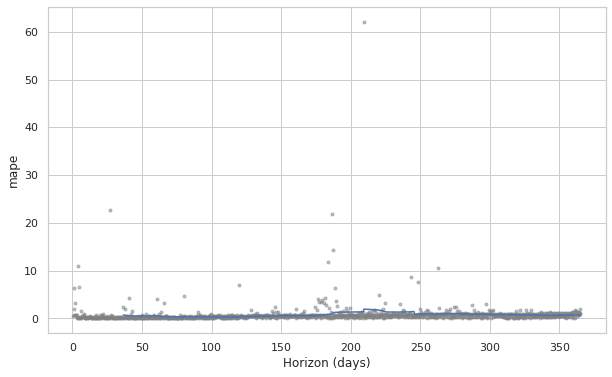

In [394]:
fig = plot_cross_validation_metric(cv_results, metric='mape')

In [211]:
# # use sklearn ParameterGrid for optimal parameter search

# from sklearn.model_selection import ParameterGrid

# params_grid = {'growth':('linear', 'logistic'),
#                'changepoint_prior_scale':[0.3, 0.7]}

# grid = ParameterGrid(params_grid)

# print([p for p in grid])

# [{'changepoint_prior_scale': 0.3, 'growth': 'linear'}, {'changepoint_prior_scale': 0.3, 'growth': 'logistic'}, {'changepoint_prior_scale': 0.7, 'growth': 'linear'}, {'changepoint_prior_scale': 0.7, 'growth': 'logistic'}]

# #then iterate through the grid iterator:
# for p in grid:
#     m =Prophet(**p)
#     m.fit(data)
#     #do scoring or diag
#     #save p and score

**With final model, make predictions on test set (2019)**

In [395]:
# create prophet object with parameters, fit with train data and predict future
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #) #100
            changepoint_prior_scale = 0.20) # .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

# fit model to entire training data
m.fit(station_cv)

# predict using test set
future = m.make_future_dataframe(periods=365, freq='d') # 181 # include_history=False) 
future['is_weekend'] = future['ds'].apply(is_weekend)
future['not_weekend'] = ~future['ds'].apply(is_weekend)
future['is_warm'] = future['ds'].apply(is_warm)
future['not_warm'] = ~future['ds'].apply(is_warm)

forecast = m.predict(future)

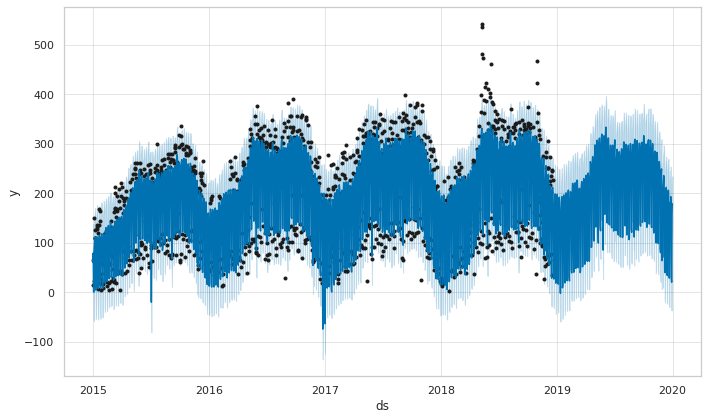

In [396]:
# plot forecast dataframe
fig1 = m.plot(forecast) 

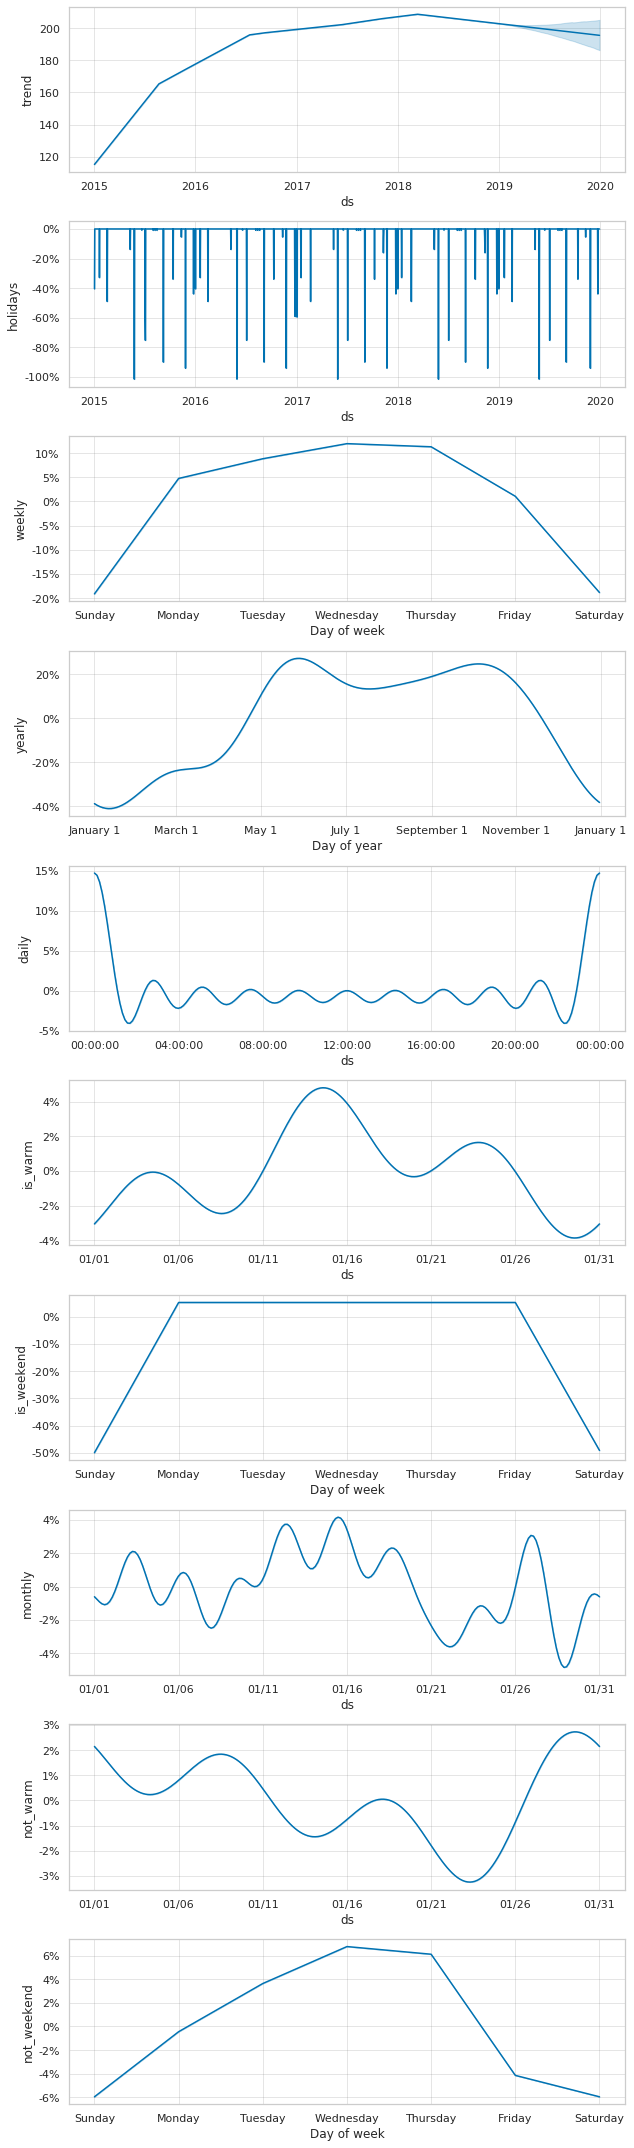

In [397]:
# plot forecast components
fig2 = m.plot_components(forecast)

In [398]:
# merge predictions back to main dataframe
citibike_pred = citibike_df[(citibike_df.station_id == 379) & 
                            (citibike_df.year == 2019)].merge( 
    forecast[['ds','yhat','yhat_lower','yhat_upper']], how='left', left_on=['date'], right_on=['ds'])

citibike_pred = citibike_pred.drop(['ds', 'year', 'month'], axis=1) # 'replace_zeroes'

citibike_pred.yhat = citibike_pred.yhat.apply(np.ceil).astype(int)

citibike_pred['error'] = citibike_pred.yhat - citibike_pred.ride_counts_clean
citibike_pred['error_abs'] = abs(citibike_pred.yhat - citibike_pred.ride_counts_clean).astype(int)
citibike_pred['error_sq'] = ((citibike_pred.yhat - citibike_pred.ride_counts_clean)**2).astype(int)

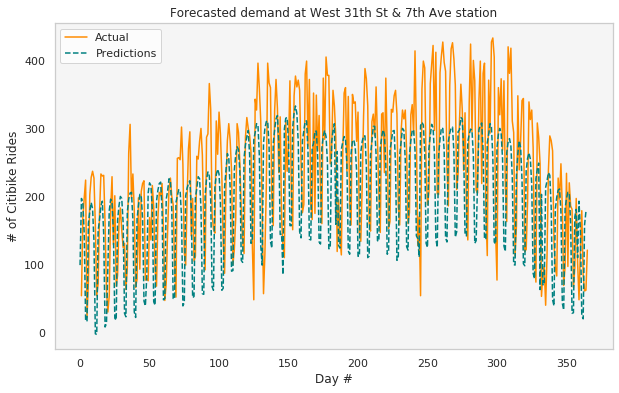

In [403]:
plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at West 31th St & 7th Ave station')

In [400]:
# evaluation metrics
print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 54.666
MAPE: 27.807
RMSE: 64.842


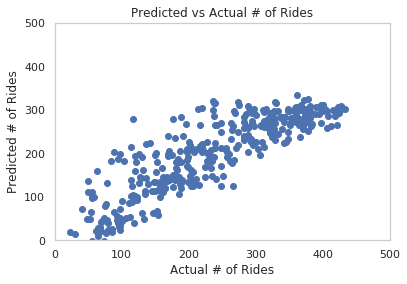

In [401]:
# plot predicted vs actual
plt.scatter(citibike_pred.ride_counts_clean, citibike_pred.yhat)
plt.title("Predicted vs Actual # of Rides"), plt.xlabel("Actual # of Rides"), plt.ylabel("Predicted # of Rides")
plt.xlim(0, 500), plt.ylim(0, 500);

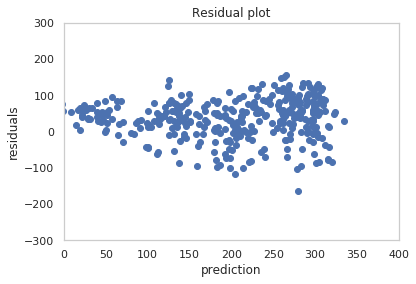

In [402]:
# plot residuals
#diagnostic_plot(X_test, y_test)
residuals = citibike_pred.ride_counts_clean - citibike_pred.yhat
plt.scatter(citibike_pred.yhat, residuals, alpha=1.0)
plt.title("Residual plot"), plt.xlabel("prediction"), plt.ylabel("residuals")
plt.xlim(0, 400), plt.ylim(-300, 300);

#### Old Fulton St (217):

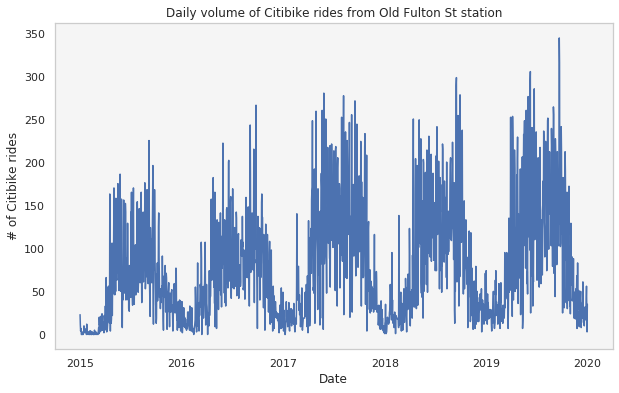

In [463]:
# plot daily ride counts for a specific station
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(citibike_df[citibike_df.station_id == 217].date, 
         citibike_df[citibike_df.station_id == 217].ride_counts_clean)
ax.set_facecolor('whitesmoke')
ax.title.set_text('Daily volume of Citibike rides from Old Fulton St station')
ax.set_xlabel('Date')
ax.set_ylabel('# of Citibike rides');

In [417]:
# split train and test for station 217
citibike_station = citibike_df.loc[citibike_df.station_id == 217, 
                                   ['date', 'is_weekend', 'not_weekend',
                                    'is_warm', 'not_warm', 'ride_counts_clean']] 

last_date = pd.Timestamp(2019, 12, 31) 
delta = timedelta(days = 364)
test_start_date = last_date - delta # test date begins 1/01/2019

station_cv = citibike_station.loc[(citibike_station.date < test_start_date), 
                                      ['date', 'is_weekend', 'not_weekend', 
                                       'is_warm', 'not_warm', 'ride_counts_clean']]

station_test = citibike_station.loc[(citibike_station.date >= test_start_date), 
                                  ['date', 'is_weekend', 'not_weekend', 
                                   'is_warm', 'not_warm', 'ride_counts_clean']]

station_cv.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']
station_test.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']

In [418]:
# create prophet object with parameters, fit with train data and run cross validation
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

m.fit(station_cv)

cv_results = cross_validation(m, initial='730 days', horizon='365 days') 
print(cv_results)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-12-31 00:00:00 and 2017-12-31 00:00:00


             ds        yhat  yhat_lower  yhat_upper   y     cutoff
0    2017-01-01   20.294635  -10.834962   51.269852  38 2016-12-31
1    2017-01-02   11.434517  -19.753692   43.743334   5 2016-12-31
2    2017-01-03   11.565875  -21.924307   42.724104   7 2016-12-31
3    2017-01-04    8.974961  -25.280906   40.084546  29 2016-12-31
4    2017-01-05    7.930181  -23.966758   37.348446  15 2016-12-31
...         ...         ...         ...         ...  ..        ...
1090 2018-12-27 -106.728054 -413.785011  204.161869  33 2017-12-31
1091 2018-12-28 -130.866974 -512.681737  230.649123  17 2017-12-31
1092 2018-12-29 -225.054370 -869.106944  404.434304  72 2017-12-31
1093 2018-12-30 -244.006029 -949.874375  458.564103  28 2017-12-31
1094 2018-12-31 -112.090411 -436.678755  202.810127  28 2017-12-31

[1095 rows x 6 columns]


In [419]:
# evaluation metrics
performance_results = performance_metrics(cv_results, metrics=['mae', 'mape', 'rmse'])
print("Mean MAE:", np.mean(performance_results.mae))
print("Mean MAPE:", np.mean(performance_results.mape))
print("Mean RMSE:", np.mean(performance_results.rmse))

Mean MAE: 194.85709506455783
Mean MAPE: 4.824448949309567
Mean RMSE: 209.83111167757943


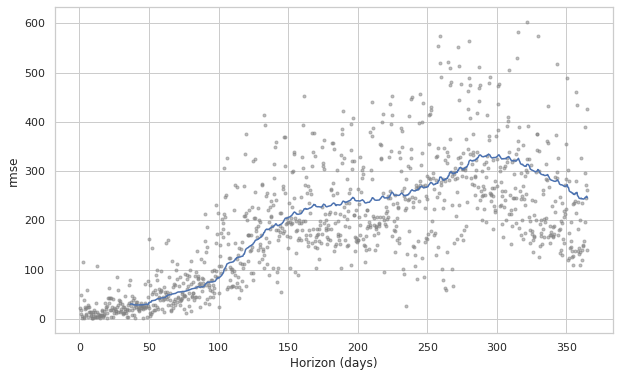

In [420]:
fig = plot_cross_validation_metric(cv_results, metric='rmse')

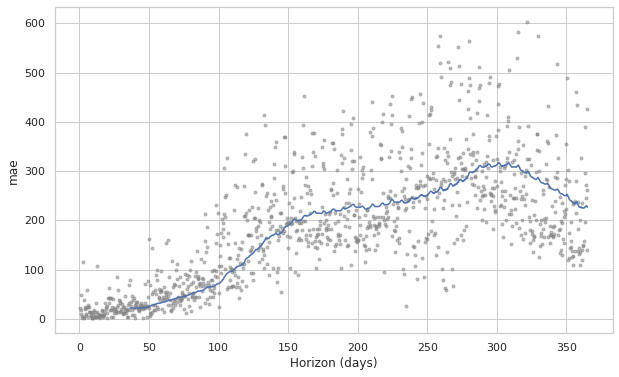

In [421]:
fig = plot_cross_validation_metric(cv_results, metric='mae')

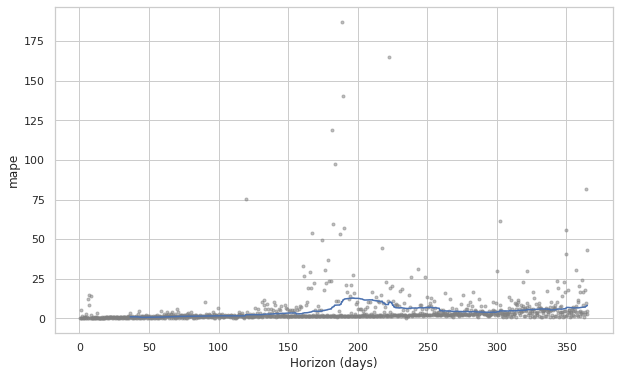

In [422]:
fig = plot_cross_validation_metric(cv_results, metric='mape')

**With final model, make predictions on test set (2019)**

In [423]:
# create prophet object with tuned parameters, fit with entire train data and predict future
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #) #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

# fit model to entire training data
m.fit(station_cv)

# predict using test set
future = m.make_future_dataframe(periods=365, freq='d') # 181 # include_history=False) 
future['is_weekend'] = future['ds'].apply(is_weekend)
future['not_weekend'] = ~future['ds'].apply(is_weekend)
future['is_warm'] = future['ds'].apply(is_warm)
future['not_warm'] = ~future['ds'].apply(is_warm)

forecast = m.predict(future)

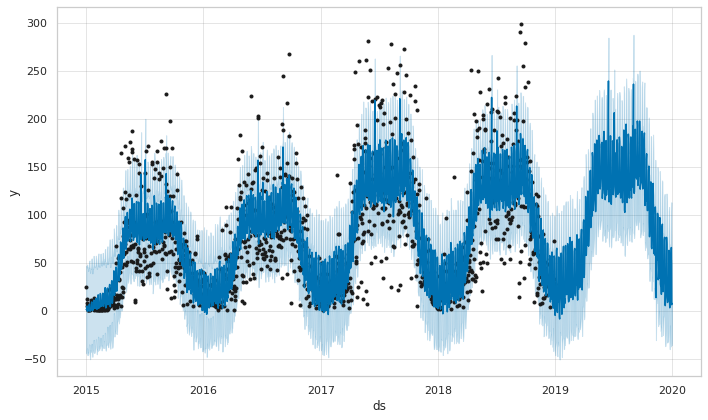

In [424]:
# plot forecast dataframe
fig1 = m.plot(forecast) 

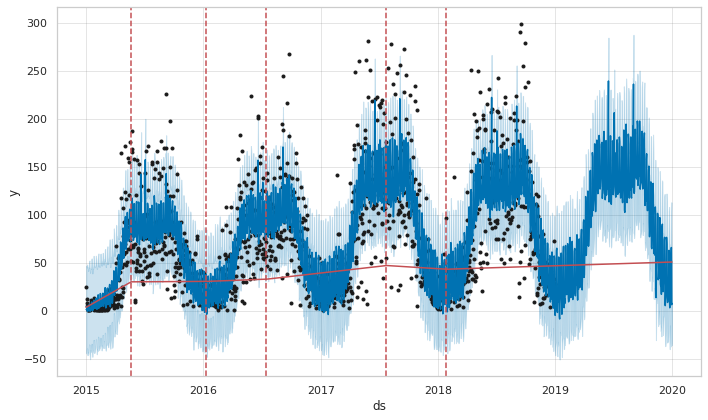

In [425]:
# locations of the signification changepoints
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

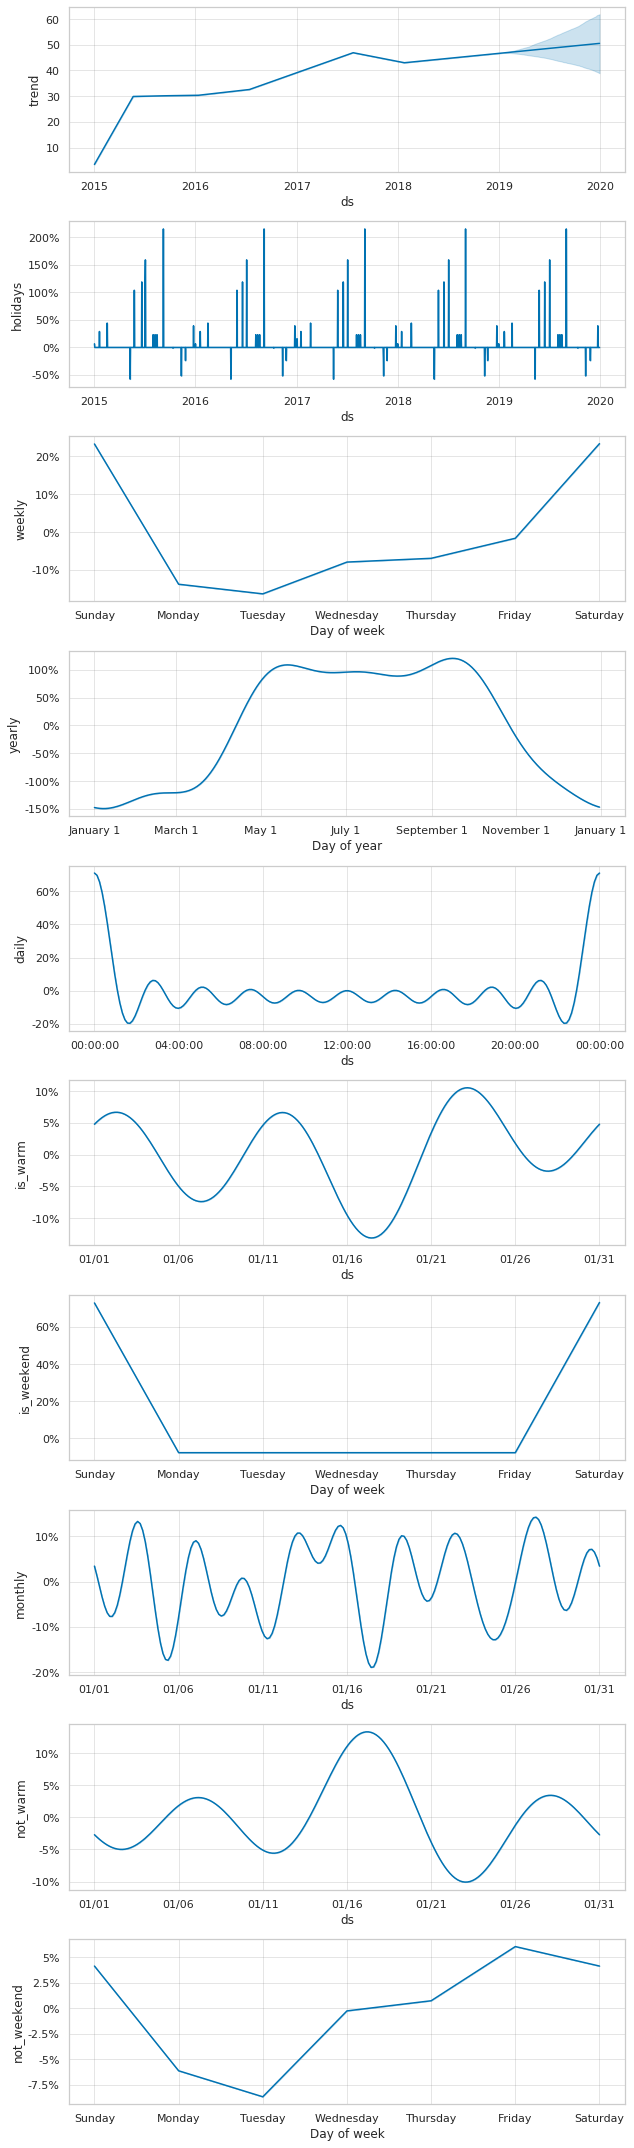

In [426]:
# plot forecast components
fig2 = m.plot_components(forecast)

In [427]:
# merge predictions back to main dataframe
citibike_pred = citibike_df[(citibike_df.station_id == 217) & 
                            (citibike_df.year == 2019)].merge( 
    forecast[['ds','yhat','yhat_lower','yhat_upper']], how='left', left_on=['date'], right_on=['ds'])

citibike_pred = citibike_pred.drop(['ds', 'year', 'month'], axis=1) # 'replace_zeroes'

citibike_pred.yhat = citibike_pred.yhat.apply(np.ceil).astype(int)

citibike_pred['error'] = citibike_pred.yhat - citibike_pred.ride_counts_clean
citibike_pred['error_abs'] = abs(citibike_pred.yhat - citibike_pred.ride_counts_clean).astype(int)
citibike_pred['error_sq'] = ((citibike_pred.yhat - citibike_pred.ride_counts_clean)**2).astype(int)

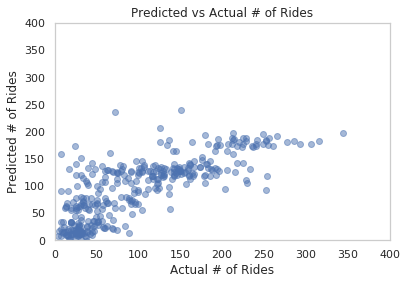

In [428]:
# plot predicted vs actual
plt.scatter(citibike_pred.ride_counts_clean, citibike_pred.yhat, alpha=0.5)
plt.title("Predicted vs Actual # of Rides"), plt.xlabel("Actual # of Rides"), plt.ylabel("Predicted # of Rides")
plt.xlim(0, 400), plt.ylim(0, 400);

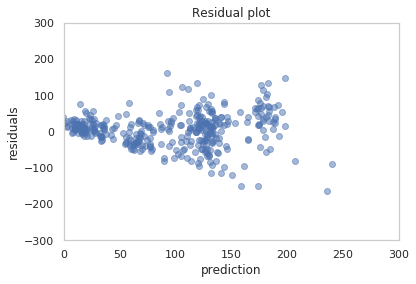

In [429]:
# plot residuals
#diagnostic_plot(X_test, y_test)
residuals = citibike_pred.ride_counts_clean - citibike_pred.yhat
plt.scatter(citibike_pred.yhat, residuals, alpha=0.5)
plt.title("Residual plot"), plt.xlabel("prediction"), plt.ylabel("residuals")
plt.xlim(0, 300), plt.ylim(-300, 300);

In [430]:
# evaluation metrics
print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 35.482
MAPE: 66.884
RMSE: 47.018


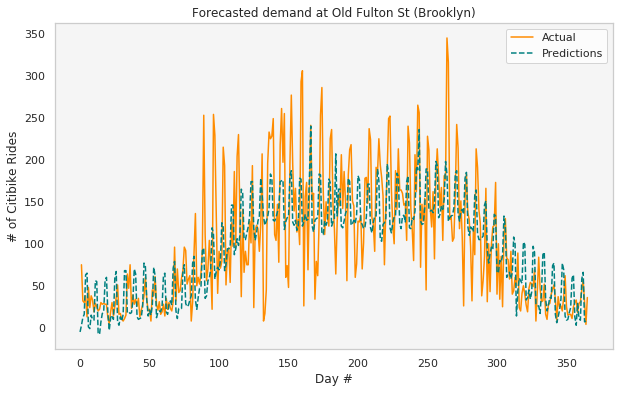

In [431]:
plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at Old Fulton St (Brooklyn)')

#### Broadway & W 60 St (499)

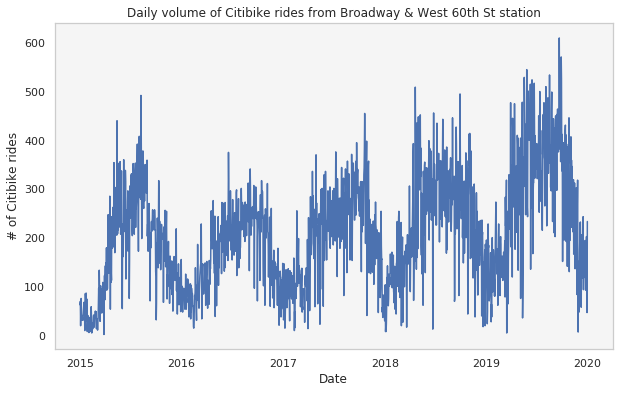

In [486]:
# plot daily ride counts for a specific station
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(citibike_df[citibike_df.station_id == 499].date, 
         citibike_df[citibike_df.station_id == 499].ride_counts_clean)
ax.set_facecolor('whitesmoke')
ax.title.set_text('Daily volume of Citibike rides from Broadway & West 60th St station')
ax.set_xlabel('Date')
ax.set_ylabel('# of Citibike rides');

In [23]:
# split train and test for station 499
citibike_station = citibike_df.loc[citibike_df.station_id == 499, 
                                   ['date', 'is_weekend', 'not_weekend',
                                    'is_warm', 'not_warm', 'ride_counts_clean']] 

last_date = pd.Timestamp(2019, 12, 31) 
delta = timedelta(days = 364)
test_start_date = last_date - delta # test date begins 1/01/2019

station_cv = citibike_station.loc[(citibike_station.date < test_start_date), 
                                      ['date', 'is_weekend', 'not_weekend', 
                                       'is_warm', 'not_warm', 'ride_counts_clean']]

station_test = citibike_station.loc[(citibike_station.date >= test_start_date), 
                                  ['date', 'is_weekend', 'not_weekend', 
                                   'is_warm', 'not_warm', 'ride_counts_clean']]

station_cv.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']
station_test.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']

In [24]:
# create prophet object with parameters, fit with train data and run cross validation
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

m.fit(station_cv)

cv_results = cross_validation(m, initial='730 days', horizon='365 days') 
print(cv_results)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-12-31 00:00:00 and 2017-12-31 00:00:00


             ds        yhat  yhat_lower  yhat_upper    y     cutoff
0    2017-01-01  108.837894   56.059269  160.525158  114 2016-12-31
1    2017-01-02   83.571643   30.570966  140.341436   32 2016-12-31
2    2017-01-03   95.276790   40.216686  150.092767   35 2016-12-31
3    2017-01-04   89.440922   34.171721  144.168871  147 2016-12-31
4    2017-01-05   76.907317   26.068234  134.334899   81 2016-12-31
...         ...         ...         ...         ...  ...        ...
1090 2018-12-27    4.547984 -558.427420  576.858964  176 2017-12-31
1091 2018-12-28    4.279423 -579.147615  602.777427   20 2017-12-31
1092 2018-12-29    4.285283 -610.656674  623.762039  187 2017-12-31
1093 2018-12-30    4.002809 -611.004812  637.152445  180 2017-12-31
1094 2018-12-31    2.840510 -467.846875  495.876007  125 2017-12-31

[1095 rows x 6 columns]


In [489]:
# evaluation metrics
performance_results = performance_metrics(cv_results, metrics=['mae', 'mape', 'rmse'])
print("Mean MAE:", np.mean(performance_results.mae))
print("Mean MAPE:", np.mean(performance_results.mape))
print("Mean RMSE:", np.mean(performance_results.rmse))

Mean MAE: 218.036049427034
Mean MAPE: 1.3460680476886249
Mean RMSE: 236.0444082121189


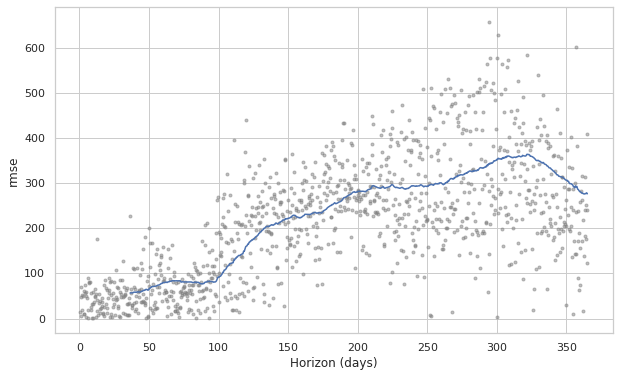

In [490]:
fig = plot_cross_validation_metric(cv_results, metric='rmse')

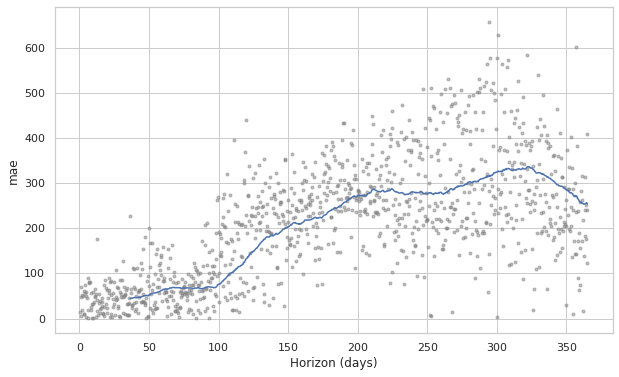

In [491]:
fig = plot_cross_validation_metric(cv_results, metric='mae')

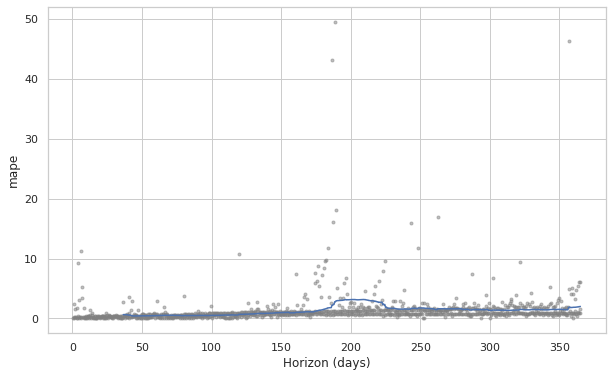

In [492]:
fig = plot_cross_validation_metric(cv_results, metric='mape')

**With final model, make predictions on test set (2019)**

In [25]:
# create prophet object with tuned parameters, fit with entire train data and predict future
m = Prophet(daily_seasonality = 10, # True 5 20 100
            #weekly_seasonality = 5, # True 10 100
            yearly_seasonality = 5, # True 10 20 100!            
            holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10, #100
            holidays_prior_scale = 10, #) #100
            changepoint_prior_scale = 0.20) # .20 .15 .25

m.add_seasonality(name='monthly', period=30, fourier_order=10) # 5 100
m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')

m.add_country_holidays(country_name='US')

# fit model to entire training data
m.fit(station_cv)

# predict using test set
future = m.make_future_dataframe(periods=365, freq='d') # 181 # include_history=False) 
future['is_weekend'] = future['ds'].apply(is_weekend)
future['not_weekend'] = ~future['ds'].apply(is_weekend)
future['is_warm'] = future['ds'].apply(is_warm)
future['not_warm'] = ~future['ds'].apply(is_warm)

forecast = m.predict(future)

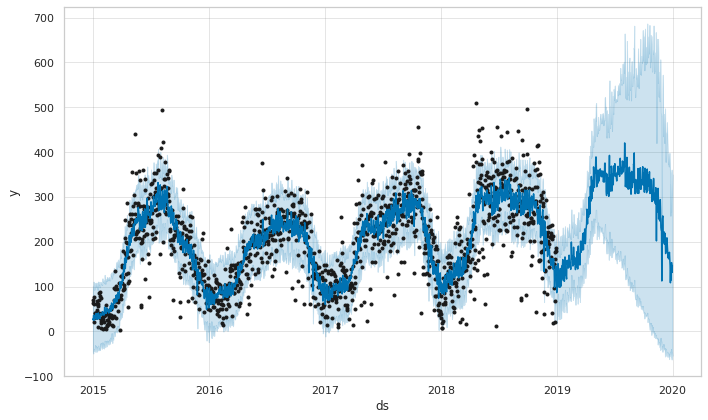

In [494]:
# plot forecast dataframe
fig1 = m.plot(forecast) 

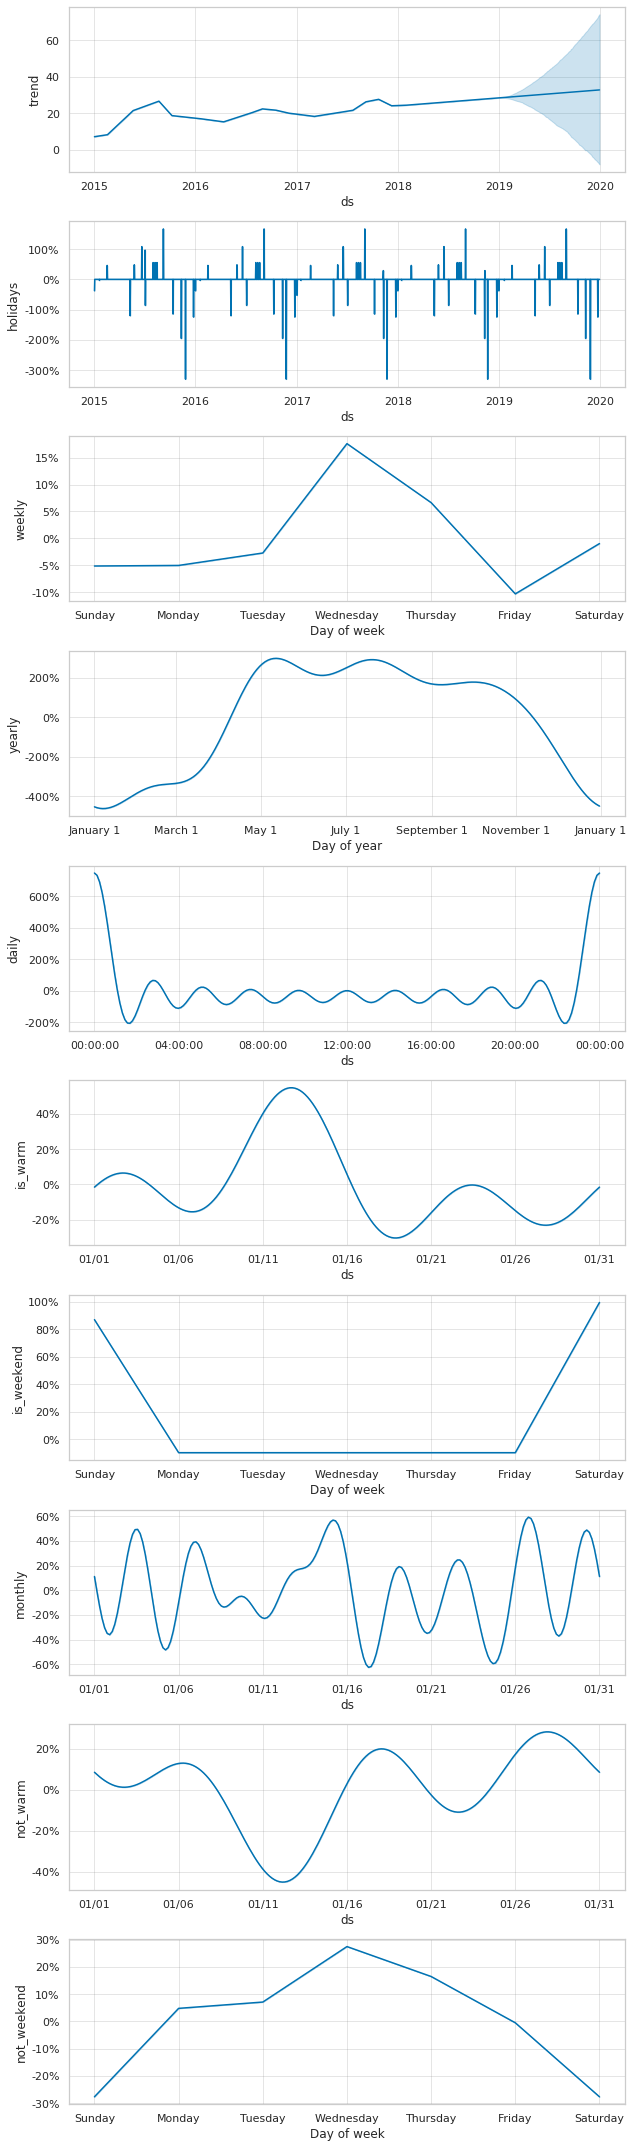

In [495]:
# plot forecast components
fig2 = m.plot_components(forecast)

In [496]:
# merge predictions back to main dataframe
citibike_pred = citibike_df[(citibike_df.station_id == 499) & 
                            (citibike_df.year == 2019)].merge( 
    forecast[['ds','yhat','yhat_lower','yhat_upper']], how='left', left_on=['date'], right_on=['ds'])

citibike_pred = citibike_pred.drop(['ds', 'year', 'month'], axis=1) # 'replace_zeroes'

citibike_pred.yhat = citibike_pred.yhat.apply(np.ceil).astype(int)

citibike_pred['error'] = citibike_pred.yhat - citibike_pred.ride_counts_clean
citibike_pred['error_abs'] = abs(citibike_pred.yhat - citibike_pred.ride_counts_clean).astype(int)
citibike_pred['error_sq'] = ((citibike_pred.yhat - citibike_pred.ride_counts_clean)**2).astype(int)

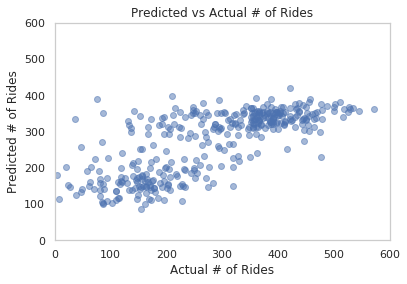

In [497]:
# plot predicted vs actual
plt.scatter(citibike_pred.ride_counts_clean, citibike_pred.yhat, alpha=0.5)
plt.title("Predicted vs Actual # of Rides"), plt.xlabel("Actual # of Rides"), plt.ylabel("Predicted # of Rides")
plt.xlim(0, 600), plt.ylim(0, 600);

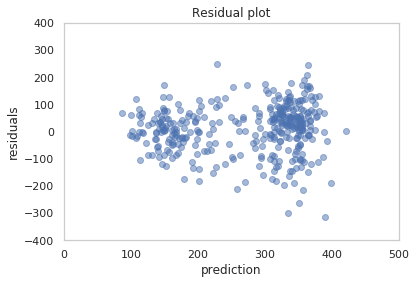

In [498]:
# plot residuals
#diagnostic_plot(X_test, y_test)
residuals = citibike_pred.ride_counts_clean - citibike_pred.yhat
plt.scatter(citibike_pred.yhat, residuals, alpha=0.5)
plt.title("Residual plot"), plt.xlabel("prediction"), plt.ylabel("residuals")
plt.xlim(0, 500), plt.ylim(-400, 400);

In [499]:
# evaluation metrics
print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 68.855
MAPE: 53.342
RMSE: 88.048


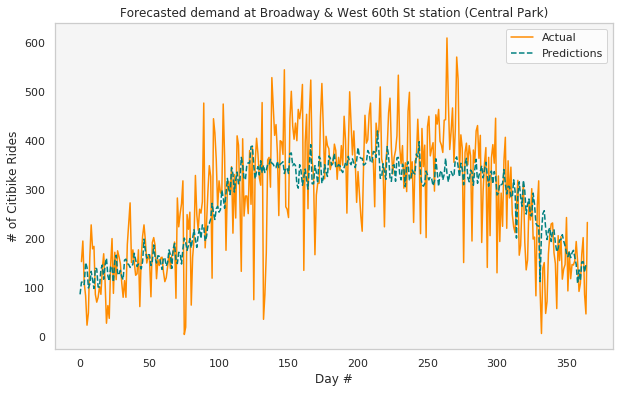

In [500]:
plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at Broadway & West 60th St station (Central Park)')

### Forecast all stations

In [52]:
# fit model to each station 

citibike_station = citibike_df.loc[(citibike_df.date < test_start_date), 
                                   ['date', 'is_weekend', 'not_weekend',
                                    'is_warm', 'not_warm', 'ride_counts_clean', 'station_id']] 

last_date = pd.Timestamp(2019, 12, 31) 
delta = timedelta(days = 364)
test_start_date = last_date - delta # test date begins 1/01/2019

forecast_dfs = []

for station in citibike_df.station_id.unique():
    
    station_cv = citibike_station.loc[(citibike_station.station_id == station), 
                                      ['date', 'is_weekend', 'not_weekend', 
                                       'is_warm', 'not_warm', 'ride_counts_clean']]
    station_cv.columns = ['ds', 'is_weekend', 'not_weekend', 'is_warm', 'not_warm', 'y']

    # create prophet object with parameters, fit with entire train data and predict on test set
    m = Prophet(daily_seasonality = 10, 
                #weekly_seasonality = 5,
                yearly_seasonality = 5, 
                holidays = holidays,
                seasonality_mode = 'multiplicative',
                seasonality_prior_scale = 10, 
                holidays_prior_scale = 10,
                changepoint_prior_scale = 0.20)

    m.add_seasonality(name='monthly', period=30, fourier_order=10) 
    m.add_seasonality(name='is_weekend', period=7, fourier_order=10, condition_name='is_weekend')
    m.add_seasonality(name='not_weekend', period=7, fourier_order=3, condition_name='not_weekend')
    m.add_seasonality(name='is_warm', period=30, fourier_order=3, condition_name='is_warm')
    m.add_seasonality(name='not_warm', period=30, fourier_order=3, condition_name='not_warm')
    m.add_country_holidays(country_name='US')
    
    m.fit(station_cv)

    future = m.make_future_dataframe(periods=365, freq='d') # 181 # include_history=False) 
    future['is_weekend'] = future['ds'].apply(is_weekend)
    future['not_weekend'] = ~future['ds'].apply(is_weekend)
    future['is_warm'] = future['ds'].apply(is_warm)
    future['not_warm'] = ~future['ds'].apply(is_warm)

    forecast = m.predict(future)
    forecast = forecast[['ds','yhat']]
    forecast['station_id'] = station 
    
    forecast_dfs.append(forecast)

#forecast_dfs
forecasts = pd.concat(forecast_dfs)
forecasts

ds       yhat  station_id
0    2015-01-01  11.523320          79
1    2015-01-02  11.135069          79
2    2015-01-03   4.265486          79
3    2015-01-04   4.615415          79
4    2015-01-05  11.749117          79
...         ...        ...         ...
1821 2019-12-27  21.526665        2022
1822 2019-12-28  11.464843        2022
1823 2019-12-29  14.699201        2022
1824 2019-12-30  23.059132        2022
1825 2019-12-31  22.294037        2022

[332332 rows x 3 columns]

In [60]:
# keep only test data
forecasts = forecasts[forecasts.ds.dt.year == 2019]

In [11]:
# pickle forecasts
#forecasts.to_pickle('forecasts.pkl')
forecasts = pd.read_pickle('forecasts.pkl')

In [73]:
# merge predictions back to main dataframe
citibike_pred_all = citibike_df.loc[citibike_df.year == 2019,                 ['station_id','date','ride_counts_clean']].merge( 
                        forecasts[['station_id','ds','yhat']], 
                        how='inner', left_on=['date', 'station_id'], right_on=['ds', 'station_id'])

citibike_pred_all = citibike_pred_all.drop(['ds'], axis=1)

citibike_pred_all.yhat = citibike_pred_all.yhat.apply(np.ceil).astype(int)

citibike_pred_all['error'] = citibike_pred_all.yhat - citibike_pred_all.ride_counts_clean
citibike_pred_all['error_abs'] = abs(citibike_pred_all.yhat - citibike_pred_all.ride_counts_clean).astype(int)
citibike_pred_all['error_sq'] = ((citibike_pred_all.yhat - citibike_pred_all.ride_counts_clean)**2).astype(int)

citibike_pred_all.head()

station_id       date  ride_counts_clean  yhat  error  error_abs  error_sq
0          79 2019-01-01                 23    29      6          6        36
1          79 2019-01-02                 31    49     18         18       324
2          79 2019-01-03                 42    48      6          6        36
3          79 2019-01-04                 67    39    -28         28       784
4          79 2019-01-05                 17    16     -1          1         1

In [8]:
# pickle all predictions and actuals
#citibike_pred_all.to_pickle('citibike_pred_all.pkl')
citibike_pred_all = pd.read_pickle('citibike_pred_all.pkl')

In [9]:
citibike_pred_all.head()

station_id       date  ride_counts_clean  yhat  error  error_abs  error_sq
0          79 2019-01-01                 23    29      6          6        36
1          79 2019-01-02                 31    49     18         18       324
2          79 2019-01-03                 42    48      6          6        36
3          79 2019-01-04                 67    39    -28         28       784
4          79 2019-01-05                 17    16     -1          1         1

In [93]:
for station in citibike_pred_all.station_id.unique():
    print(station)

79
119
120
127
128
143
144
146
150
151
157
164
168
174
195
216
217
236
237
239
241
242
243
244
245
248
249
252
254
258
259
261
262
264
265
266
268
275
276
278
279
281
282
285
289
295
296
297
301
302
303
305
307
308
309
310
311
313
315
317
320
321
323
324
325
326
327
328
330
331
332
334
335
336
339
340
341
342
343
344
346
350
351
353
354
355
356
358
359
360
361
363
364
366
369
372
373
377
379
380
383
386
387
388
389
391
393
394
396
397
398
399
400
402
406
408
410
411
412
415
416
417
418
419
422
426
427
432
435
436
437
440
445
446
447
454
455
458
459
460
461
466
471
472
473
476
478
479
481
482
484
486
487
491
492
494
496
497
499
501
504
507
514
515
516
517
519
525
528
529
530
531
532
534
536
546
2000
2008
2009
2012
2021
2022


In [96]:
# evaluation metrics

mape_dict = {}
mae_dict = {}
rmse_dict = {}

for station in citibike_pred_all.station_id.unique():
    station_pred = citibike_pred_all.loc[citibike_pred_all.station_id == station,]
    y_actual = station_pred.ride_counts_clean
    y_pred = station_pred.yhat 
    mape_dict[station] = mape(y_actual, y_pred)
    mae_dict[station] = mae(y_actual, y_pred)
    rmse_dict[station] = rmse(y_actual, y_pred)
  
print('Mean MAPE: ', np.array(list(mape_dict.values())).mean().round(5))  
print('Mean MAE: ', np.array(list(mae_dict.values())).mean().round(5))
print('Mean RMSE: ', np.array(list(rmse_dict.values())).mean().round(5)) 

Mean MAPE:  36.9907
Mean MAE:  31.68769
Mean RMSE:  39.96626


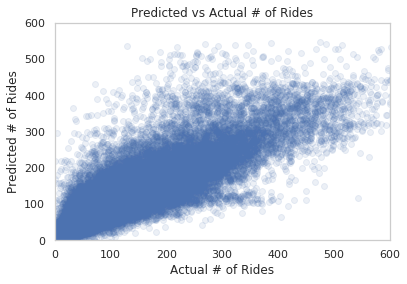

In [99]:
# plot predicted vs actual
plt.scatter(citibike_pred_all.ride_counts_clean, citibike_pred_all.yhat, alpha=0.1)
plt.title("Predicted vs Actual # of Rides"), plt.xlabel("Actual # of Rides"), plt.ylabel("Predicted # of Rides")
plt.xlim(0, 600), plt.ylim(0, 600);

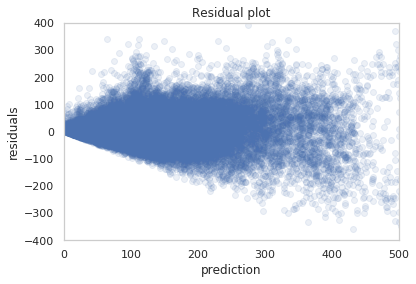

In [100]:
# plot residuals
#diagnostic_plot(X_test, y_test)
residuals = citibike_pred_all.ride_counts_clean - citibike_pred_all.yhat
plt.scatter(citibike_pred_all.yhat, residuals, alpha=0.1)
plt.title("Residual plot"), plt.xlabel("prediction"), plt.ylabel("residuals")
plt.xlim(0, 500), plt.ylim(-400, 400);

In [91]:
citibike_pred_all[citibike_pred_all.station_id == 499]

station_id       date  ride_counts_clean  yhat  error  error_abs  \
57670         499 2019-01-01                154    87    -67         67   
57671         499 2019-01-02                196   112    -84         84   
57672         499 2019-01-03                110   112      2          2   
57673         499 2019-01-04                 84   107     23         23   
57674         499 2019-01-05                 24   152    128        128   
...           ...        ...                ...   ...    ...        ...   
58030         499 2019-12-27                169   115    -54         54   
58031         499 2019-12-28                203   153    -50         50   
58032         499 2019-12-29                 87   154     67         67   
58033         499 2019-12-30                 47   132     85         85   
58034         499 2019-12-31                234   148    -86         86   

       error_sq  
57670      4489  
57671      7056  
57672         4  
57673       529  
57674     16384  
...         ...  
58030      2916  
58031      2500  
58032      4489  
58033      7225  
58034      7396  

[365 rows x 7 columns]

TypeError: 'str' object is not callable

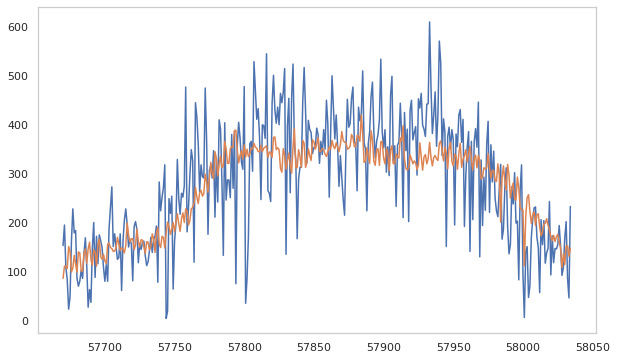

In [129]:
plt.figure(figsize=(10,6))
plt.plot(citibike_pred_all[citibike_pred_all.station_id == 499].ride_counts_clean)
plt.plot(citibike_pred_all[citibike_pred_all.station_id == 499].yhat)
plt.title('Forecasted demand at Broadway & West 60th St station (Central Park)');

## Forecast with WaveNet

**See wavenet exog notebook from google colab**

In [9]:
citibike_df.head()

date  station_id              station_name  station_latitude  \
0 2015-01-01          79  Franklin St & W Broadway         40.719116   
1 2015-01-02          79  Franklin St & W Broadway         40.719116   
2 2015-01-03          79  Franklin St & W Broadway         40.719116   
3 2015-01-04          79  Franklin St & W Broadway         40.719116   
4 2015-01-05          79  Franklin St & W Broadway         40.719116   

   station_longitude  mean_duration  year  month  day_of_week  is_weekend  \
0         -74.006667     880.133333  2015      1            3       False   
1         -74.006667    1499.818182  2015      1            4       False   
2         -74.006667     432.266667  2015      1            5        True   
3         -74.006667     693.666667  2015      1            6        True   
4         -74.006667     669.000000  2015      1            0       False   

   not_weekend  is_warm  not_warm  ride_counts_clean  
0         True    False      True                 15  
1         True    False      True                 22  
2        False    False      True                 15  
3        False    False      True                 27  
4         True    False      True                 27

In [16]:
# create dataframe with dates as columns and stations as rows
df_all = citibike_df.pivot(index='station_id', columns='date', values='ride_counts_clean')
df_all.head()

date        2015-01-01  2015-01-02  2015-01-03  2015-01-04  2015-01-05  \
station_id                                                               
79                  15          22          15          27          27   
119                  3           3           3           5           5   
120                  4           1           4           4           4   
127                 41          52          19          33          65   
128                 24          51          13          16          76   

date        2015-01-06  2015-01-07  2015-01-08  2015-01-09  2015-01-10  ...  \
station_id                                                              ...   
79                  21          16          14          15          14  ...   
119                  4           8           3           4           2  ...   
120                  2           1           1           1           2  ...   
127                 42          45          24          32          29  ...   
128                 38          44          30          41          42  ...   

date        2019-12-22  2019-12-23  2019-12-24  2019-12-25  2019-12-26  \
station_id                                                               
79                  30          52          32          19          36   
119                  6          22           8           5           8   
120                 25          22          20          10          13   
127                 61          79          43          18          48   
128                 77          78          63          21          62   

date        2019-12-27  2019-12-28  2019-12-29  2019-12-30  2019-12-31  
station_id                                                              
79                  55          20          19          12          42  
119                 10          19          13          10           9  
120                 26          20          15           8          21  
127                 69          60          44          34          88  
128                 69          77          39          28          81  

[5 rows x 1826 columns]

In [17]:
# subset to only training dates - exclude all of 2019
df = df_all.loc[:, df_all.columns[:(1826-365)]]

In [18]:
# reformat column names
df = df.reset_index()
df = df.rename_axis(None)
df.columns = df.columns.astype(str)
df.columns = df.columns.astype(str).str.replace(' 00:00:00', '')

In [19]:
df.head()

date  station_id  2015-01-01  2015-01-02  2015-01-03  2015-01-04  2015-01-05  \
0             79          15          22          15          27          27   
1            119           3           3           3           5           5   
2            120           4           1           4           4           4   
3            127          41          52          19          33          65   
4            128          24          51          13          16          76   

date  2015-01-06  2015-01-07  2015-01-08  2015-01-09  ...  2018-12-22  \
0             21          16          14          15  ...          35   
1              4           8           3           4  ...           6   
2              2           1           1           1  ...          21   
3             42          45          24          32  ...          54   
4             38          44          30          41  ...          58   

date  2018-12-23  2018-12-24  2018-12-25  2018-12-26  2018-12-27  2018-12-28  \
0             33          26          18          27          32           9   
1              7           7           2           2           3           2   
2              8           7           6          12           8           4   
3             51          42          26          55          71          34   
4             54          41          27          49          74          31   

date  2018-12-29  2018-12-30  2018-12-31  
0             18          21          24  
1              8           4           3  
2             27          15          10  
3             52          52          35  
4             75          43          46  

[5 rows x 1462 columns]

In [20]:
# date range of training data
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-01-01 to 2018-12-31


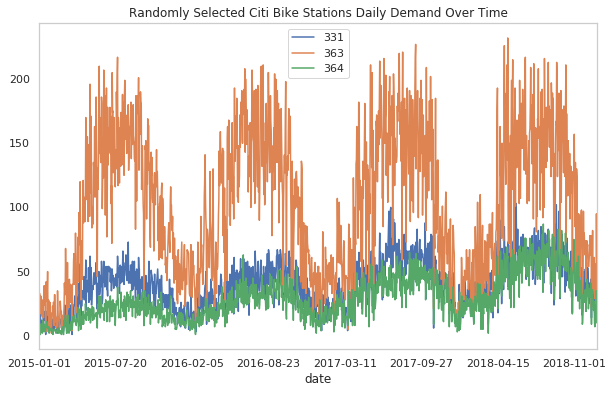

In [10]:
def plot_random_series(df, n_series):
    
    sample = df.sample(n_series, random_state=24)
    station_labels = sample['station_id'].tolist()
    series_samples = sample.loc[:, data_start_date:data_end_date]
    
    plt.figure(figsize=(10,6))
    
    for i in range(series_samples.shape[0]):
        (pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)
    
    plt.title('Randomly Selected Citi Bike Stations Daily Demand Over Time')
    plt.legend(station_labels)
    
plot_random_series(df, 3)

### Train and Validation Series Partioning

**Create 4 sub-segments of the data:**.   
1. Train encoding period  
2. Train decoding period (train targets, 60 days)  
3. Validation encoding period  
4. Validation decoding period (validation targets, 60 days)  

In [516]:
print(data_start_date, "to", data_end_date)

2015-01-01 to 2018-12-31


In [46]:
pred_steps = 365 
pred_length = timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date) # gradually increase start end date (for overlapping windows)?

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)

In [47]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)

In [23]:
print('Train encoding:', train_enc_start.strftime('%Y-%m-%d'), 'to', train_enc_end.strftime('%Y-%m-%d'))
print('Train prediction:', train_pred_start.strftime('%Y-%m-%d'), 'to', train_pred_end.strftime('%Y-%m-%d'))
print('\nVal encoding:', val_enc_start.strftime('%Y-%m-%d'), 'to', val_enc_end.strftime('%Y-%m-%d'))
print('Val prediction:', val_pred_start.strftime('%Y-%m-%d'), 'to', val_pred_end.strftime('%Y-%m-%d'))

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2015-01-01 to 2016-12-31
Train prediction: 2017-01-01 to 2017-12-31

Val encoding: 2016-01-01 to 2017-12-31
Val prediction: 2018-01-01 to 2018-12-31

Encoding interval: 731
Prediction interval: 365


**Keras data formatting**

In [48]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values

def get_time_block_series(series_array, date_to_index, start_date, end_date):

    inds = date_to_index[start_date:end_date]
    return series_array[:, inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0], series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0], series_array.shape[1], 1))
    
    return series_array

### CNN setup

In [25]:
# convolutional operation parameters
n_filters = 32 # 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] * 2 

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':365})(out)

model = Model(history_seq, pred_seq_train)
model.compile(Adam(), loss='mean_absolute_error')

In [50]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, None, 16)     32          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, None, 32)     1056        conv1d_67[0][0]                  
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, None, 32)     1056        conv1d_67[0][0]                  
____________________________________________________________________________________________

### Fit and train the model

In [26]:
# define early stopping with tensorflow
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [27]:
# set number of epochs
first_n_samples = 120000
batch_size = 2**11
epochs = 1000 # 100, 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Train on 145 samples, validate on 37 samples
Epoch 1/1000
145/145 [==============================] - 25s 171ms/step - loss: 0.5403 - val_loss: 0.5172
Epoch 2/1000
145/145 [==============================] - 4s 31ms/step - loss: 0.5193 - val_loss: 0.4964
Epoch 3/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.4945 - val_loss: 0.4742
Epoch 4/1000
145/145 [==============================] - 4s 29ms/step - loss: 0.4673 - val_loss: 0.4528
Epoch 5/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.4404 - val_loss: 0.4351
Epoch 6/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.4172 - val_loss: 0.4287
Epoch 7/1000
145/145 [==============================] - 4s 27ms/step - loss: 0.4082 - val_loss: 0.4354
Epoch 8/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.4146 - val_loss: 0.4350
Epoch 9/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.4159 - val_loss: 0.4239
Epoch 10/1000
145/145 [===

Epoch 80/1000
145/145 [==============================] - 4s 29ms/step - loss: 0.2753 - val_loss: 0.2697
Epoch 81/1000
145/145 [==============================] - 4s 31ms/step - loss: 0.2744 - val_loss: 0.2680
Epoch 82/1000
145/145 [==============================] - 4s 24ms/step - loss: 0.2732 - val_loss: 0.2664
Epoch 83/1000
145/145 [==============================] - 3s 24ms/step - loss: 0.2725 - val_loss: 0.2651
Epoch 84/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.2718 - val_loss: 0.2640
Epoch 85/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.2712 - val_loss: 0.2631
Epoch 86/1000
145/145 [==============================] - 4s 29ms/step - loss: 0.2706 - val_loss: 0.2621
Epoch 87/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.2697 - val_loss: 0.2609
Epoch 88/1000
145/145 [==============================] - 4s 30ms/step - loss: 0.2695 - val_loss: 0.2597
Epoch 89/1000
145/145 [==============================] - 5s 31ms

Epoch 159/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.2419 - val_loss: 0.2304
Epoch 160/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.2419 - val_loss: 0.2287
Epoch 161/1000
145/145 [==============================] - 4s 27ms/step - loss: 0.2404 - val_loss: 0.2284
Epoch 162/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.2403 - val_loss: 0.2295
Epoch 163/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.2407 - val_loss: 0.2291
Epoch 164/1000
145/145 [==============================] - 4s 29ms/step - loss: 0.2402 - val_loss: 0.2281
Epoch 165/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.2392 - val_loss: 0.2278
Epoch 166/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.2391 - val_loss: 0.2282
Epoch 167/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.2392 - val_loss: 0.2276
Epoch 168/1000
145/145 [==============================]

145/145 [==============================] - 4s 27ms/step - loss: 0.2220 - val_loss: 0.2113
Epoch 238/1000
145/145 [==============================] - 4s 27ms/step - loss: 0.2223 - val_loss: 0.2117
Epoch 239/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.2228 - val_loss: 0.2100
Epoch 240/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.2215 - val_loss: 0.2098
Epoch 241/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.2206 - val_loss: 0.2099
Epoch 242/1000
145/145 [==============================] - 4s 24ms/step - loss: 0.2207 - val_loss: 0.2092
Epoch 243/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.2205 - val_loss: 0.2097
Epoch 244/1000
145/145 [==============================] - 4s 24ms/step - loss: 0.2204 - val_loss: 0.2094
Epoch 245/1000
145/145 [==============================] - 4s 27ms/step - loss: 0.2197 - val_loss: 0.2095
Epoch 246/1000
145/145 [==============================] - 4s 27ms/step

Epoch 316/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.2068 - val_loss: 0.1973
Epoch 317/1000
145/145 [==============================] - 3s 23ms/step - loss: 0.2056 - val_loss: 0.1973
Epoch 318/1000
145/145 [==============================] - 3s 24ms/step - loss: 0.2059 - val_loss: 0.1974
Epoch 319/1000
145/145 [==============================] - 4s 27ms/step - loss: 0.2055 - val_loss: 0.1970
Epoch 320/1000
145/145 [==============================] - 3s 23ms/step - loss: 0.2058 - val_loss: 0.1967
Epoch 321/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.2050 - val_loss: 0.1969
Epoch 322/1000
145/145 [==============================] - 3s 24ms/step - loss: 0.2054 - val_loss: 0.1962
Epoch 323/1000
145/145 [==============================] - 4s 27ms/step - loss: 0.2044 - val_loss: 0.1962
Epoch 324/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.2047 - val_loss: 0.1965
Epoch 325/1000
145/145 [==============================]

145/145 [==============================] - 4s 27ms/step - loss: 0.1945 - val_loss: 0.1866
Epoch 395/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.1940 - val_loss: 0.1865
Epoch 396/1000
145/145 [==============================] - 3s 22ms/step - loss: 0.1929 - val_loss: 0.1875
Epoch 397/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.1938 - val_loss: 0.1877
Epoch 398/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.1953 - val_loss: 0.1882
Epoch 399/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.1949 - val_loss: 0.1867
Epoch 400/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.1935 - val_loss: 0.1860
Epoch 401/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.1930 - val_loss: 0.1868
Epoch 402/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.1932 - val_loss: 0.1863
Epoch 403/1000
145/145 [==============================] - 4s 26ms/step

Epoch 473/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.1853 - val_loss: 0.1801
Epoch 474/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.1851 - val_loss: 0.1799
Epoch 475/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.1854 - val_loss: 0.1799
Epoch 476/1000
145/145 [==============================] - 4s 27ms/step - loss: 0.1855 - val_loss: 0.1803
Epoch 477/1000
145/145 [==============================] - 4s 26ms/step - loss: 0.1856 - val_loss: 0.1801
Epoch 478/1000
145/145 [==============================] - 4s 28ms/step - loss: 0.1858 - val_loss: 0.1802
Epoch 479/1000
145/145 [==============================] - 4s 27ms/step - loss: 0.1855 - val_loss: 0.1801
Epoch 480/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.1855 - val_loss: 0.1794
Epoch 481/1000
145/145 [==============================] - 4s 25ms/step - loss: 0.1849 - val_loss: 0.1795
Epoch 482/1000
145/145 [==============================]

In [45]:
# save trained model

# creates a HDF5 file 'my_model.h5'
#model.save('wavenet_1000_epochs', save_format = ‘h5’) 
#model.save('wavenet_1000_epochs') 
#model.save('wavenet_1000_epochs.h5') 

# deletes the existing model
del model  

# returns a compiled model identical to the previous one
model = load_model('wavenet_1000_epochs.h5') # wavenet_100_epochs

# check its architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, None, 16)     32          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_68 (Conv1D)              (None, None, 32)     1056        conv1d_67[0][0]                  
__________________________________________________________________________________________________
conv1d_69 (Conv1D)              (None, None, 32)     1056        conv1d_67[0][0]                  
____________________________________________________________________________________________

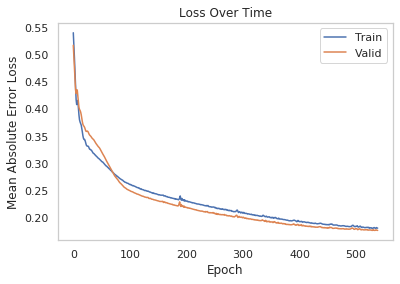

In [30]:
# plot convergence curve of train / validation loss - 1000 EPOCHS (539/1000, loss: 0.1812 - val_loss: 0.1770)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid']);

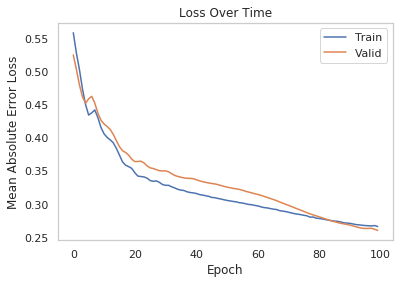

In [21]:
# plot convergence curve of train / validation loss - 100 EPOCHS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid']);

### Generate predictions

In [49]:
# get and transform encoder and decoder data for both input and target

encoder_input_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [32]:
# function to generate predictions by running our model with inference loop
def predict_sequence(input_sequence):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-1,0]
        pred_sequence[0,i,0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,1,1)], axis=1)

    return pred_sequence

In [33]:
# function to add encode series mean back to encoder input data, then take inverse logp
def inverse_transform(encoder_input_data, encode_series_mean):
    encode_series_mean = np.expand_dims(encode_series_mean, axis=1)
    encoder_input_data = np.add(encoder_input_data, encode_series_mean)
    encoder_input_data = np.expm1(encoder_input_data) 
    return encoder_input_data

In [ ]:
# get predictions and mae for each of the 182 stations 

# for index in range(0, 182):
    
#     encode_series = encoder_input_data[index:index+1,:,:]
#     pred_series = predict_sequence(encode_series)

#     y_pred = inverse_transform(pred_series, encode_series_mean[index]).squeeze()
#     y_actual = df_all.iloc[index,-365:]

#     mae_dict = {}
#     mape_dict = {}
#     rmse_dict = {}
#     mae_dict[index] = mae(y_actual, y_pred).round(5)
#     mape_dict[index] = mape(y_actual, y_pred).round(5)
#     rmse_dict[index] = rmse(y_actual, y_pred).round(5)

# print('Mean MAE:', sum(mae_dict.values()) / float(len(mae_dict)))
# print('Mean MAPE:', sum(mape_dict.values()) / float(len(mape_dict)))
# print('Mean RMSE:', sum(rmse_dict.values()) / float(len(rmse_dict)))

### Compare model results on the select stations

In [529]:
#stations 491, 379, 499 and 217
print("index for station 491:", df_all.index.get_loc(491))
print("index for station 379:", df_all.index.get_loc(379))
print("index for station 499:", df_all.index.get_loc(499))
print("index for station 217:", df_all.index.get_loc(217))

index for station 491: 153
index for station 379: 98
index for station 499: 158
index for station 217: 16


#### E 24 St & Park Ave S

MAE:  89.88544
MAPE:  51.59844
RMSE:  128.58106


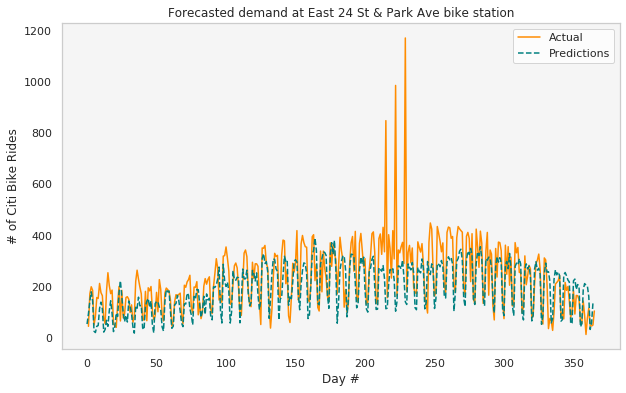

In [35]:
# CNN model: calculate and plot predictions vs actual for station 491 (index 153) - 1000 EPOCHS 
encode_series = encoder_input_data[153:153+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[153]).squeeze()
y_actual = df_all.iloc[153,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at East 24 St & Park Ave bike station')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

In [50]:
# CNN model: calculate and plot predictions vs actual for station 491 (index 153) - 1000 EPOCHS from SAVED MODEL
encode_series = encoder_input_data[153:153+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[153]).squeeze()
y_actual = df_all.iloc[153,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at East 24 St & Park Ave bike station')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

KeyboardInterrupt: 

MAE:  92.81563
MAPE:  62.0823
RMSE:  125.29455


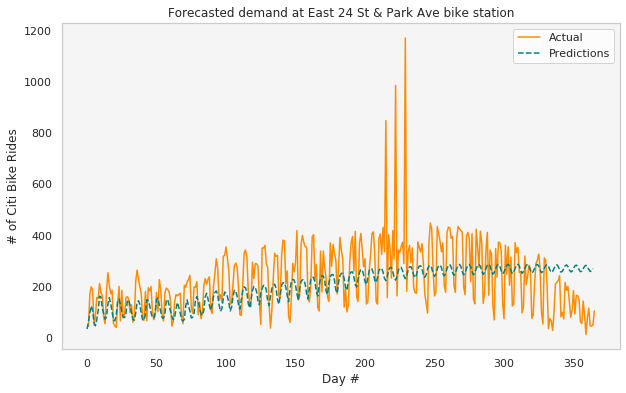

In [26]:
# CNN model: calculate and plot predictions vs actual for station 491 (index 153) - 100 EPOCHS
encode_series = encoder_input_data[153:153+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[153]).squeeze()
y_actual = df_all.iloc[153,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at East 24 St & Park Ave bike station')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

In [376]:
# facebook prophet results
# evaluation metrics
# print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
# print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
# print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 78.797
MAPE: 53.321
RMSE: 101.032


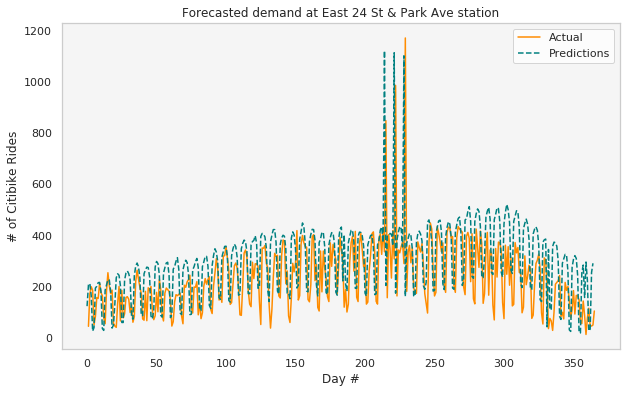

In [388]:
# facebook prophet results
# plot predictions vs actual
# plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at East 24 St & Park Ave bike station')

#### W 31 St 7 Ave

MAE:  74.40438
MAPE:  45.21879
RMSE:  95.53604


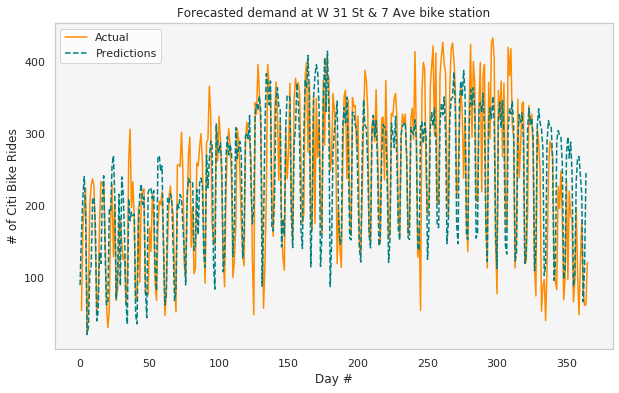

In [38]:
# CNN model: calculate and plot predictions vs actual for station 379 (index 98) - 1000 EPOCHS
encode_series = encoder_input_data[98:98+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[98]).squeeze()
y_actual = df_all.iloc[98,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at W 31 St & 7 Ave bike station')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

MAE:  56.91475
MAPE:  38.09045
RMSE:  69.71771


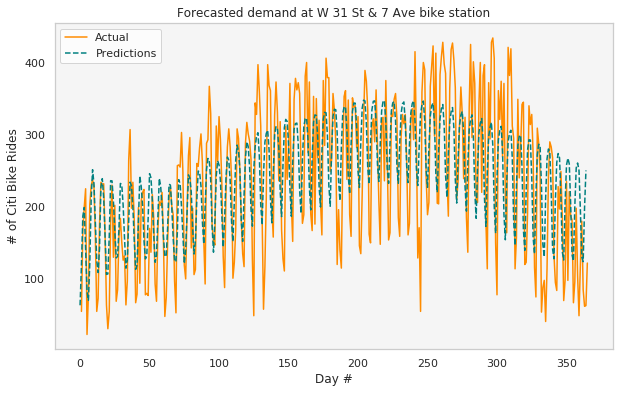

In [27]:
# CNN model: calculate and plot predictions vs actual for station 379 (index 98) - 100 epochs
encode_series = encoder_input_data[98:98+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[98]).squeeze()
y_actual = df_all.iloc[98,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at W 31 St & 7 Ave bike station')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

In [400]:
# facebook prophet results
# evaluation metrics
# print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
# print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
# print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 54.666
MAPE: 27.807
RMSE: 64.842


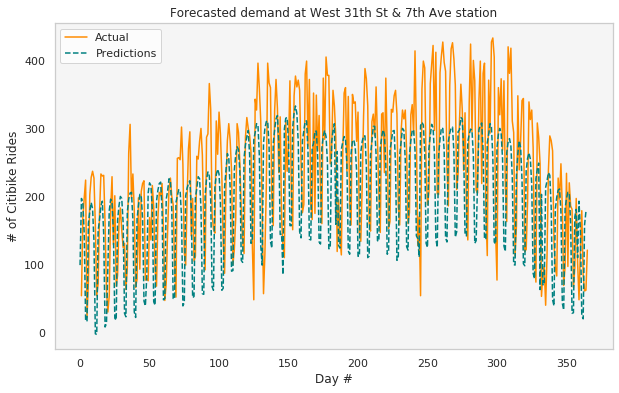

In [403]:
# facebook prophet results
# plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at West 31th St & 7th Ave bike station')

#### Old Fulton St

MAE:  96.20701
MAPE:  102.43123
RMSE:  122.30504


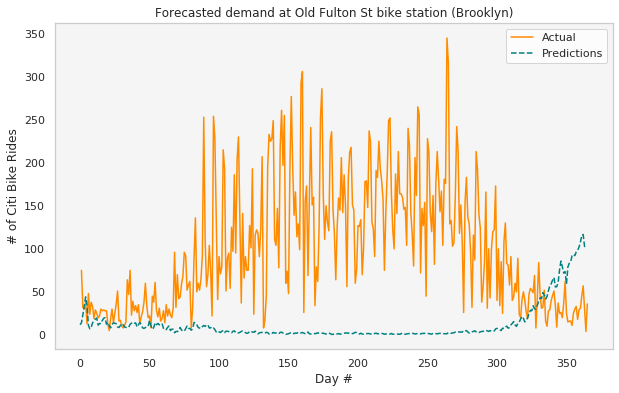

In [39]:
# CNN model: calculate and plot predictions vs actual for station 217 (index 16) - 1000 EPOCHS
encode_series = encoder_input_data[16:16+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[16]).squeeze()
y_actual = df_all.iloc[16,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at Old Fulton St bike station (Brooklyn)')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

MAE:  51.93246
MAPE:  110.74641
RMSE:  68.12025


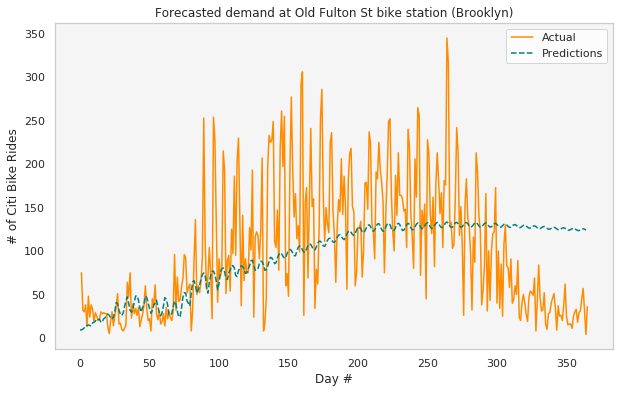

In [28]:
# CNN model: calculate and plot predictions vs actual for station 217 (index 16) - 100 EPOCHS
encode_series = encoder_input_data[16:16+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[16]).squeeze()
y_actual = df_all.iloc[16,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at Old Fulton St bike station (Brooklyn)')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

In [430]:
# facebook prophet results
# evaluation metrics
# print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
# print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
# print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 35.482
MAPE: 66.884
RMSE: 47.018


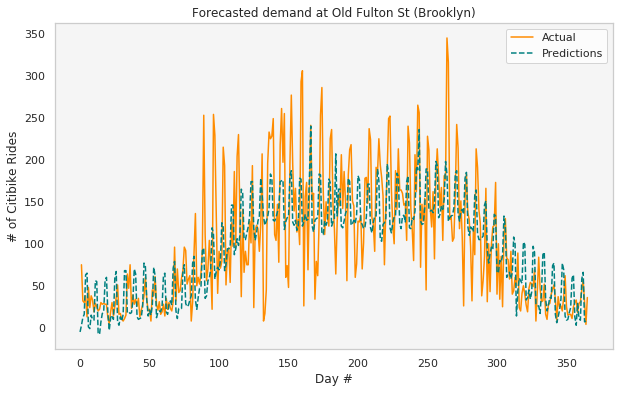

In [431]:
# facebook prophet results
# plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at Old Fulton St station (Brooklyn)')

#### Broadway & W 60 St

MAE:  108.51095
MAPE:  56.40186
RMSE:  132.32222


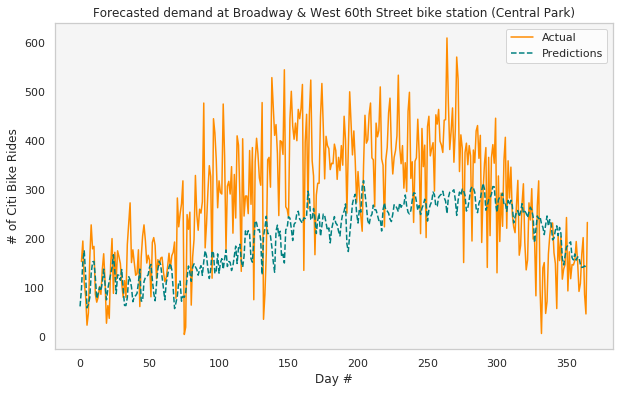

In [40]:
# CNN model: calculate and plot predictions vs actual for station 499 (index 158) - 1000 EPOCHS
encode_series = encoder_input_data[158:158+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[158]).squeeze()
y_actual = df_all.iloc[158,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at Broadway & West 60th Street bike station (Central Park)')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

MAE:  101.32233
MAPE:  76.59089
RMSE:  130.94818


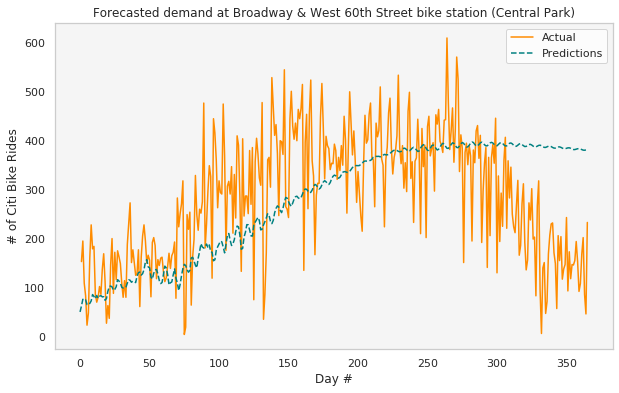

In [29]:
# CNN model: calculate and plot predictions vs actual for station 499 (index 158) - 100 EPOCHS
encode_series = encoder_input_data[158:158+1,:,:]
pred_series = predict_sequence(encode_series)
y_pred = inverse_transform(pred_series, encode_series_mean[158]).squeeze()
y_actual = df_all.iloc[158,-365:]

fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(range(1,365+1), y_actual, color='darkorange')
ax.plot(y_pred, color='teal', linestyle='--')

ax.set_facecolor('whitesmoke')
ax.title.set_text('Forecasted demand at Broadway & West 60th Street bike station (Central Park)')
ax.set_xlabel('Day #')
ax.set_ylabel('# of Citi Bike Rides')
ax.legend(['Actual','Predictions']);

# evaluation metrics
print('MAE: ', mae(y_actual, y_pred).round(5))
print('MAPE: ', mape(y_actual, y_pred).round(5))
print('RMSE: ', rmse(y_actual, y_pred).round(5))     

In [499]:
# facebook prophet results
# evaluation metrics
# print("MAE:", mae(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
# print("MAPE:", mape(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))
# print("RMSE:", rmse(citibike_pred.ride_counts_clean, citibike_pred.yhat).round(3))

MAE: 68.855
MAPE: 53.342
RMSE: 88.048


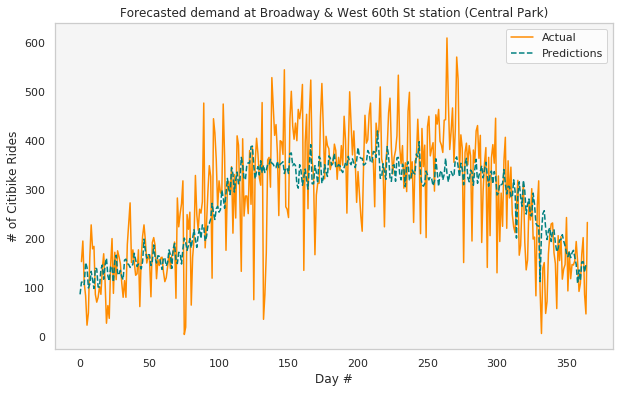

In [500]:
# facebook prophet results
# plot_forecast(citibike_pred.ride_counts_clean, citibike_pred.yhat, title='Forecasted demand at Broadway & West 60th St station (Central Park)')

In [56]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = predict_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

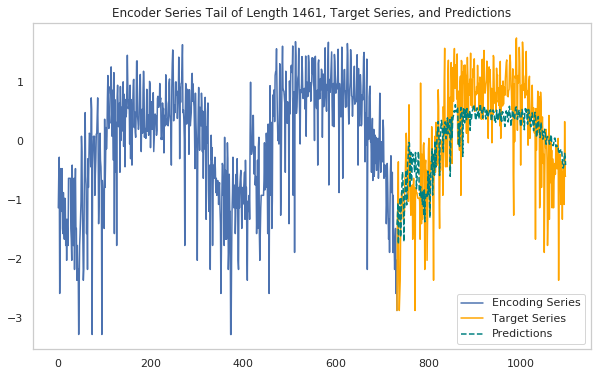

In [57]:
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16, enc_tail_len=1461) 

In [ ]:
index for station 491: 153
index for station 379: 98
index for station 499: 158
index for station 217: 16

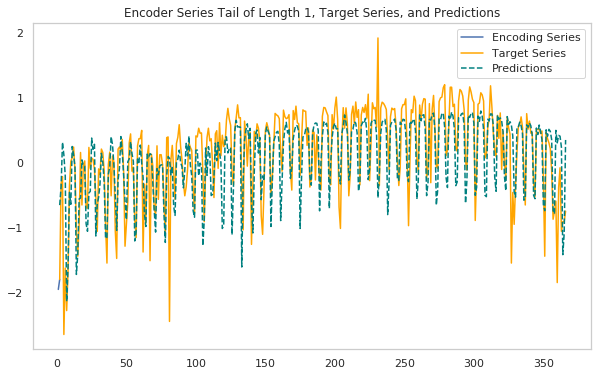

In [58]:
# station 491
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=153, enc_tail_len=1)

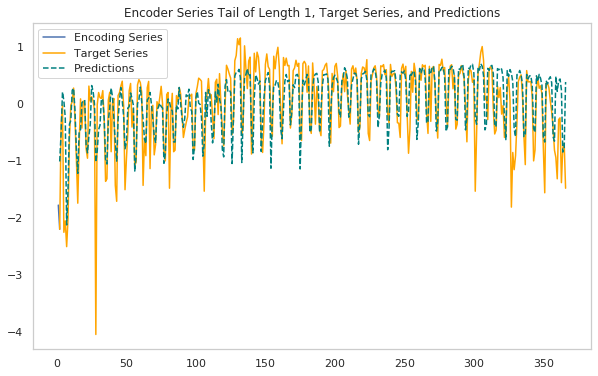

In [59]:
# station 379
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=98, enc_tail_len=1)

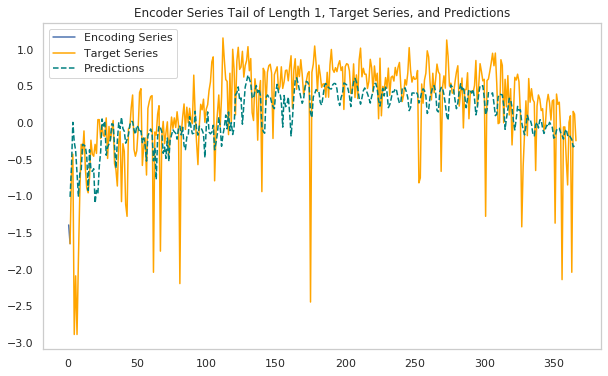

In [60]:
# station 499
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=158, enc_tail_len=1)

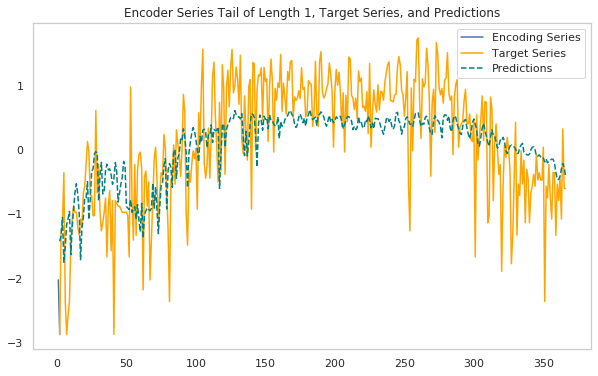

In [61]:
# station 217
predict_and_plot(encoder_input_data, decoder_target_data, 
                 sample_ind=16, enc_tail_len=1)